# Design of a pseudo-spectral Poisson solver

# A. Motivation

The evolution of a plasma system is tied to field equations. For the case of electrostatics ($B = 0$), we consider Boltzmann-Gauss/Poisson systems. At this juncture, DECSKS apprehends the Vlasov-Poisson system which requires solution to Poisson's equation (or, Gauss' law) in order to evolve this collisionless plasma system self-consistently, according to either equivalent set of equations:

\begin{eqnarray*}
\frac{\partial f}{\partial t} + v\frac{\partial f}{\partial x} + \frac{\partial\phi}{\partial x}\frac{\partial f}{\partial v} = 0, \qquad &  \text{and } & \qquad \frac{\partial^2 \phi}{\partial x^2} = \int_v dv f(t,x,v) - n_0  \\[2em]
& \text{or } & \\[2em]
\frac{\partial f}{\partial t} + v\frac{\partial f}{\partial x} - E\frac{\partial f}{\partial v} = 0, \qquad & \text{and } & \qquad \frac{\partial E}{\partial x} = n_0 -  \int_v dv f(t,x,v)
\end{eqnarray*}

For some domains $x\in \mathcal{D}_x, v\in \mathcal{D}_v$. 

For periodic domains (periodic extensions of non-periodic domains), solving Poisson's equation (Gauss' law) can be facilitated by Fourier-based methods, which inherit the superior convergence and accuracy of spectral methods (also, their hangups, e.g. Gibbs oscillations near sharp transition regions).

# B. Goals of this notebook

This notebook focuses on the design of pseudo-spectral (Fourier-based) solutions of the equations on the right-hand side of the above set. Fourier-based methods operate on globally interpolating functions, giving rise to its well-known convergence and accuracy properties. In [1], a Gauss' law Fourier based method is discussed, we repeat equivalent information (the only difference should be that the reference chooses an asymmetric wave number interval).

Solution of the differential equations proceed by electing to differentiate not the function itself (e.g. finite differencing), but instead to differentiate the unique trigonometric interpolation of the function (i.e. the function is projected onto the subspace spanned by complex-valued exponentials in $\mathbb{C}^{n}$, a <i>Fourier transform</i>) so that differentiation is reduced to algebraic multiplication whereafter the obtained derivative can be mapped back onto $\mathbb{R}^n$ (<i>inverse Fourier transform</i>). The efficiency of the transform procedure can be reduced to $O(N_x\log N_x)$ operations for a mesh characterized by $N_x$ grid points, by a divide-and-conquer strategy that recursively groups wave numbers into bins of progressively half the number of wave numbers $N_x$, which constitute the well-known class of algorithms known as the <i>fast Fourier transform (FFT)</i> (e.g. radix-2). Because of the Fourier basis whose basis functions globally interpolate the function, we inherit spectral-like properties and accuracy that is also well-known to be unmatched by any other means.

# C. Setup and definitions

We consider the forms given in section A [1]:

\begin{eqnarray*}
 \frac{\partial E}{\partial x} = n_0 -  \int_v dv f(t,x,v)\qquad &  \text{or } & \qquad \frac{\partial^2 \phi}{\partial x^2} = \int_v dv f(t,x,v) - n_0 
\end{eqnarray*}

where $\partial_x\phi = -E$, and $\phi = \phi (t,x)$ and $E = E(t,x)$.


The ion density is taken to be a cold background (constant) value, chosen so that $n_i \equiv n_0$ maintains quasineutrality globally, i.e. equal to the total number of charge carriers $N_e$ over the length of the domain $L = b - a$ that constitute the electron density $n_e \equiv n$. On scales of the Debye length (note that in the Vlasov model above, $x$ has been normalized by $\lambda_D$ so that it measures multiples of the Debye length) localized electric fields are not sufficiently screened out, as computed by Poisson's equation/Gauss' law. To find the value of the ion background density, we calculate the total number of electrons $N_e$ for the initial distribution:

$$N_e = \int_a^b dx \int_v dv f(t,x,v) = \int_a^b dx \int_v dv f_0(x,v)$$

then, since the number of positive ions, $\int_a^b dx n_0$, must equal this number, and $n_0 = \text{const}$, we have

$$n_0 = \frac{N_e}{b - a}$$

In future work, the ion density can be permitted to evolve alongside the electron distribution by the straightforward inclusion of a Vlasov equation for the ion species distribution function $f_i = f_i(t,x,v)$ and where the ion density $n_i \neq \text{constant}$, but $n_i = \int_v dv f_i(t,x,v)$. In this notebook, we do not address this extension as it is straightforward, <font color = "red">(TODO) but may return to include such details later</font> 

## C.1. Transform definitions

The projection onto the subspace of complex exponentials permits expressing any <i>periodic</i> function as a trigonometric series:

$$f(x) = \sum_{k = -\infty}^{\infty} \mathcal{F}[f](\xi_k) e^{\text{i}\xi_k x}, \quad \xi_k = \frac{2\pi k}{L}$$

<i>(for non-periodic functions, the period $L$ is infinite. Thus, in the limit $L\to\infty$, we have the spacing between each linear frequency $\Delta\nu = \Delta k / L \rightarrow 0$ and arrive at an integral formulation $\xi_k \to 2\pi\nu_k$. That is to say, a continuum of superposed wave frequencies are needed to converge to the original function in the RMSE sense)</i>

Note, the imaginary unit $\text{i} = \sqrt{-1}$ is formatted in plain text to avoid any confusion with the usual grid index associated with the first configurational variable $i$ that is most often used by this author. In the limit above where an infinite number of waves are added (many contributions may be negligible given periodicity), the RMS error between a Fourier series and the function is zero. 

The <i>wave number</i> (or <i>wave frequency</i>) has the form $\xi_k = 2\pi k / L$ for $k\in\mathbb{Z}$, where the name listed parenthetically is common due to Fourier analysis having origins in frequency/time signals, sometimes we call $k/L = \nu_k$, the linear <i>frequency</i>, which is related to a wave <i>period</i> $T_k = 1 / \nu_k = L / k$ for $L = b - a$, where $x\in [a,b]$ for $a,b\in\mathbb{R}$ that are at least large enough to contain one full period. Hence, the coefficient $\mathcal{F}[f](\xi_k)$ can be referred to as the $k$th frequency, or <i>Fourier</i>, component, or even Fourier mode. That is, the set $\{\mathcal{F}[f](\xi_k)\}$ are the aforementioned projections onto the complex exponentials with wave numbers $\{\xi_k\}$, which are obvious when viewing the above series. That is, we multiply by a complex exponential function of the same family and integrate over a period:

\begin{eqnarray*}
\int_{-L/2}^{L/2} dx f(x) e^{-\frac{2\pi\text{i}k}{L}}  & = & \int_{-L/2}^{L/2} dx\sum_{m  =  -\infty}^{\infty} \mathcal{F}[f](m) e^{\frac{2\pi\text{i}m}{L}} e^{-\frac{2\pi\text{i}k}{L}} \\[1em]
\int_{-L/2}^{L/2} dx f(x) e^{-\frac{2\pi\text{i}k}{L}}  & = & \sum_{m  =  -\infty}^{\infty} \mathcal{F}[f](m) \left(\int_{-L/2}^{L/2} dx e^{\frac{2\pi\text{i}(m - k)}{L}}\right) \\[1em]
\int_{-L/2}^{L/2} dx f(x) e^{-\frac{2\pi\text{i}k}{L}}  & = & \sum_{m  =  -\infty}^{\infty} \mathcal{F}[f](m)(L\delta_{mk}) \\[1em]
\int_{-L/2}^{L/2} dx f(x) e^{-\frac{2\pi\text{i}k}{L}}  & = & \mathcal{F}[f](k) L
\end{eqnarray*}

Thus,

$$\mathcal{F}[f](k) = \frac{1}{L}\int_{-L/2}^{L/2} f_L(x) e^{-\frac{2\pi\text{i}}{L}kx}dx = \frac{(f, e^{\frac{2\pi\text{i}}{L}kx})}{(e^{\frac{2\pi\text{i}}{L}kx}, e^{\frac{2\pi\text{i}}{L}kx})} \qquad \underline{\text{Forward (Fourier) transform}}$$

Where the inner product is defined as $(A, B) =  \langle B | A \rangle = \int_{\mathbb{x\in \mathcal{D}}} dx A\bar{B} = \int_{x\in\mathcal{D}} dx B^*A$. The backward transform is easily understood as:

$$\mathcal{F}^{-1}[\mathcal{F}[f_L](k)] = f_L(x) = \int_{-L/2}^{L/2} \mathcal{F}[f_L](k) e^{\frac{2\pi\text{i}}{L}kx}dx = (e^{\frac{2\pi\text{i}}{L}kx},f) \qquad \underline{\text{Backward (inverse Fourier) transform}}$$

On a computer, we write $x_m = m\Delta x = m \frac{L}{N_x}$, $m = 0, 1, \ldots , N_x - 1$. To move from a continuous to a discrete domain is either a long-winded exercise, or follows from waving our hands. We describe the former, <font color = "red">(TODO) which might be shown in another notebook in detail </font>. The rigorous transition involves writing down discrete representations of the continuous function using summations of delta functions $f_{\Delta}(x_m) = f(x)\sum_{m=0}^{N_x - 1}\delta (x - x_m) = \sum_{m=0}^{N_x - 1}f(x_m)\delta (x - x_m)$. We then take its continuous Fourier transform, $\mathcal{F}[f_{\Delta}]$ where the transform of the delta function is computed trivially. Recogizing we have put only one foot in the discrete domain (forming $f_{\Delta}$), but still have the other in the continuum domain (using a continous transform $\mathcal{F}$) we acknowledge more work is needed. Thus, we write an appropriate representation to find $\mathcal{F}[f_{\Delta}]_{\Delta} := \text{DFT}$, the <i>discrete Fourier transform</i> which in tautological terms is the discretized Fourier transform of the discretized function. This again, is done with $\delta$-functions, $\mathcal{F}[f_{\Delta}]_{\Delta}(\nu_k) = \mathcal{F}[f_{\Delta}](\nu )\sum_{k = 0}^{M_{\nu} - 1} \delta (\nu - \nu_k)$, where $\nu_k = k / L$. To remove all traces of the continuum version, we require replacing discrete terms like $x_m$ and $\nu_k$, and to understand the relationship between the number of samples $M_{\nu}$ in frequency space and $N_x$ in real space. By invoking the Shannon interpolation theorem carefully we see the appropriate number is indicated such that $M_{\nu} = N_x$ where the spacing in the $x$ domain is $\Delta x = 1 / L$, and the appearing product $x_m\nu_k$ in the complex exponential of $\mathcal{F}[f_{\Delta}]$ can be written as $mk / N_x$. In this way, we successfully step into a discrete domain while removing all continuum dependencies and can work exclusively with intrinsic and natural labels that characterize the discrete data sets $\{m,k,N_x\}$. 

Alternatively, many authors (defensibly) decide to brazenly skip such a stepthrough and cover tracks by introducing the credible and believable "definitions" of the DFT and IDFT. Which are the same statements as we would produce from the preceding paragraph. That is, we find that the appropriate forms of the DFT and IDFT are given by:

$$\mathcal{F}[f](\xi_k) \simeq \text{DFT}[f](k)  := \frac{1}{N_x} \sum_{m = 0}^{N_x - 1} f(x_m) e^{-\text{i}\xi_k x_m}$$


$$f(x_m) \simeq \text{IDFT}[\text{DFT}[f]](m)  := \sum_{k = 0}^{N_x - 1}\text{DFT}[f](k) e^{\text{i}\xi_k x_m}$$

If a fast Fourier transform (FFT) algorithm is used, then the above transform pair can be written as:

$$\mathcal{F}[f](\xi_k) \simeq \text{FFT}[f](k)  := \frac{1}{N_x} \sum_{m = 0}^{N_x - 1} f(x_m) e^{-\text{i}\xi_k x_m}$$


$$f(x_m) \simeq \text{IFFT}[\text{FFT}[f]](m)  := \sum_{k = 0}^{N_x - 1}\text{FFT}[f](k) e^{\text{i}\xi_k x_m}$$

where we have used the grid points $x_m$ and calculable wave numbers $\xi_k$. In response to the paragraph just before this, it can be seen that $x_m\xi_k = 2\pi m k / N_x$ if desired.


## C.2. Conservation of energy

A Vlasovian plasma conserves any constant of motion, $C = C(f)$, hence the total energy is conserved, $W_E = W_E(f, E(f))$, or $W_E = W_E(f,\phi (f))$:

$$W_E = \int_{x\in\mathcal{D}_x} dx \int_{v\in\mathcal{D}_v}\frac{1}{2}f(x,v)v^2 dv + \int_{x\in\mathcal{D}_x}\frac{1}{2}|E(x)|^2 dx $$

or,

$$W_E = \int_{x\in\mathcal{D}_x} dx \int_{v\in\mathcal{D}_v} \frac{1}{2}f(x,v)v^2 dv+ \int_{x\in\mathcal{D}_x}dx\left(\int_{v\in\mathcal{D}_v} f(x,v) dv - n_0\right)\phi (x)$$

for the case of a constant singly charged ion background density. These statements express the interchanges of energy between particles and the electrostatic field. Hence, the sum of these two energies remain fixed in time; any drop in energy stored by the field is manifest in corresponding rises in particle energy and vice versa. In other words, for a periodic system we partition $\mathbb{R}$ in space as the union of identical cells over smaller domains $\mathcal{D}_x \subset \mathbb{R}$, where the union is completed by periodicity from one cell to the next. Thus, in order to conserve energy for the total space, the electrostatic field cannot have an average non-zero field, else the end points of neighboring cells cannot be matched. This can be enforced directly if $E$ is computed in a Gauss' law solver, or can be equivalently reported as periodic boundary conditions of the electric potential $\phi$.

# D. Gauss' law solver

We solve the discrete problem at each $x_i$ inside the domain $x\in [a, b]$, and enumerate according to $i = 0, 1, 2, \ldots , N_x - 1$.

The right-hand side of Gauss' law is the charge density $\rho (x)$ which for our model case of a constant singly charged ion background density $n_0$ and an evolving distribution function for electrons can be computed as $\rho (x) = n_0 -  \int_v dv f(t,x,v)$, or discretely as $\rho_i = n_0 - \sum_j \Delta v_j f_{i,j}^n$ for $f_{i,j}^n \equiv f(t^n, x_i, v_j)$, and $\rho_i \equiv \rho (x_i)$, then the governing equation is:

$$\left(\frac{\partial E}{\partial x}\right)_{x = x_i} = \rho_i$$

For the Fourier algorithm, we develop the continuum version (transforms $\mathcal{F}$ and $\mathcal{F}^{-1}$), then assert the discrete case ($\text{FFT}/\text{IFFT}$) holds:

\begin{eqnarray*}
\frac{\partial E}{\partial x} & = & \rho \\
\end{eqnarray*}

For reasons that will be clear soon enough, we partition the electric field $E$ as

$$E(t,x) = \langle E \rangle + \tilde{E}(t,x)$$

where $\langle E \rangle \equiv \langle E \rangle_x$ is averaged over the configuration variable $x$. In particular, it will be seen that the transformed Gauss' law precludes computing all the components involved in the transformed field $\mathcal{F}E$ directly since the $k = 0$ Fourier mode equation is not useful ("$0 = 0$") and does not provide a means to calculate $\mathcal{F}E(0)$ (and hence the DC component $\mathcal{F}^{-1}\mathcal{F}E(0) \equiv \langle E \rangle$ is not obtainable). Notwithstanding, we understand that while the DC field component ($k = 0$) in inaccessible directly, the following formulation does give all the information of every other harmonic ($k \neq 0$) which describes <i>fluctuations</i> from the mean value $\langle E \rangle$. Thus, it is seen that the scheme allows for computation of fluctuating field $\tilde{E}(t,x) = E(t,x) - \langle E \rangle$(i.e. $\langle \tilde{E} \rangle = 0$, whose Fourier DC component is defined as $\mathcal{F}\tilde{E}(k=0) = 0$. If we can find or know the mean field $\langle E \rangle$ (e.g. if $\langle E \rangle$ is a constant external field applied) then the above partition allows calculation of the total field $E$. Hence, we separate the contributions to the total field $E$ as above.

For our purposes, the plasma conserves energy so worrying about the mean field is not a concern ($\langle E \rangle = 0$ is required for energy conservation). Thus, for this special case, $E(t,x) = \tilde{E}(t,x)$ and the algorithm described provides us with the exact field required in the intended context (Vlasov-Poisson plasma kinetic solver). Note, for generality, we keep the diacritic $\sim$ on symbols to indicate that it is the fluctuating parts we are solving for (though the rendering may make it appear as an overbar incidentally), and that while our restricted applications to energy conservative plasma systems have the fortune that this happens to correspond to the total field, it is not the case for all readers. 

Thus, instead of the above equation, we consider solving the fluctuating field by means of Fourier methods:

\begin{eqnarray*}
\frac{\partial \tilde{E}}{\partial x} & = & \tilde{\rho} \\
\end{eqnarray*}

where $\tilde{E} = E - \langle E \rangle_x$, and $\tilde{\rho} = \rho - \langle \rho \rangle_x$, and $\langle \cdot \rangle_x$ denotes the average over the configuration variable $x$.

Apply the continuous forward transform:

\begin{eqnarray*}
\mathcal{F}\left[\frac{\partial \tilde{E}}{\partial x}\right](k) & = & \mathcal{F}[\tilde{\rho}](k) \\
\frac{1}{L}\int_{-L/2}^{L/2}\frac{\partial \tilde{E}}{\partial x} e^{-\frac{\text{i}\xi_k}{L}x}dx & = & \mathcal{F}\tilde{\rho} \\
\underbrace{\frac{1}{L}\left(\tilde{E}e^{-\text{i}\xi_k x}\right)_{-L/2}^{L/2}}_{=\, 0,\, \text{periodicity}} - (-\text{i}\xi_k) \underbrace{\frac{1}{L}\int_{-L/2}^{L/2}\tilde{E} e^{-\text{i}\xi_k x}dx}_{= \mathcal{F}[\tilde{E}](k)} & = & \mathcal{F}\tilde{\rho} \\
\text{i}\xi_k \mathcal{F}[\tilde{E}](k) & = & \mathcal{F}[\tilde{\rho} ] (k), \qquad \text{for all } \xi_k = \frac{2\pi k}{L}, \, k = \{0, 1, \ldots , N_x - 1 \} \qquad (*)
\end{eqnarray*}

This last equation is valid for all $k$, and in particular for each $k \neq 0$ it provides relationships whereby each $\mathcal{F}\tilde{E}(k \neq 0)$ can be solved for in terms of each $\mathcal{F}\tilde{\rho}(k \neq 0)$. Note, the $k = 0$ term does not provide an equation that involves $\mathcal{F}\tilde{E}(0)$ (i.e. the equation for $k = 0$ pertains to $\xi_k = 2\pi (0) / L = 0$, so the above equation is $0 = \mathcal{F}[\rho] (0)$). This only gives information about the DC component of the fluctuating density, which was already known to be zero beforehand since by definition the mean of a fluctuating quantity is zero. Hence, the $k = 0$ is not useful. This result where the $k = 0$ component does not give information about the transformed field is the aforementioned reason why we cannot use a Fourier method to obtain information about the DC component ($k = 0$), $\mathcal{F}E(0)$. That is, if we used $E$ in the above equation, rather than $\tilde{E}$  (hence, $\rho$ instead of $\tilde{\rho}$), then in efforts to find $\mathcal{F}E(0)$, we would have the $k = 0$ component giving $0 = \mathcal{F}\rho(0)$, which is not only not helpful as it does not give any means to calculate $\mathcal{F}E(0)$, but it is also incorrect in many cases as $\mathcal{F}\rho (0) \neq 0$ in general. In fact, this observation speaks to a larger platform than just a Fourier solver incidentally. In our efforts to solve the problem using Fourier transforms, we have revealed an inner detail that amounts to a <b>compatiblity, or solubility, condition</b> on the periodic Gauss or Poisson problem: a periodic problem has no solution if the average density is nonzero. The condition is that periodic boundary conditions require that $\langle \rho \rangle = 0$. The converse is also true, namely that direct application of Fourier methods can only give solutions to periodic problems (i.e. where $\langle \rho \rangle \sim \frac{1}{b - a}\int_a^b \rho dx = 0$). Later we will apply additional means to recover solutions for non-periodic cases, but these introductions are on top of the Fourier method, they do not make the Fourier method itself more robust or overcome its limitations, but instead use the information it gives in order to assemble a total solution by appending a homogeneous solution in a systematic way. 

It is for this reason we understand that a Fourier method can at best only provide the solution of $\tilde{E}$, whereafter the total soution $E$ must be assembled as mentioned: $E = \langle E\rangle + \tilde{E}$ provided the average value is known or calculable by some means (not the focus of this notebook).
eeded (the $k \neq 0$ equations).

Concretely, we write

$$\mathcal{F}[\tilde{E}](k) = \begin{cases}
0, & k = 0 \\
& \\
\frac{1}{\mathrm{i}\xi_k}\mathcal{F}[\tilde{\rho}](k), & k = 1, 2, \ldots , N_x - 1, \, \xi_k = \frac{2\pi k}{L}\end{cases}$$

<font color = "blue">We notice a means that saves modest computational efforts in the above set of equations.  Since the $k = 0$ equation is unneeded, we only require $\mathcal{F}\tilde{\rho}(k\neq 0)$. But, the only measure by which $\mathcal{F}\tilde{\rho}$ differs from $\mathcal{F}\rho$ is the unnneded $k =0$ mode. Hence, since $\mathcal{F}\rho (k \neq 0) = \mathcal{F}\tilde{\rho}(k \neq 0)$, the above set of equations can be equivalently represented with $\tilde{\rho}\to\rho$</font>:

$$\mathcal{F}[\tilde{E}](k) = \begin{cases}
0, & k = 0 \\
& \\
\frac{1}{\mathrm{i}\xi_k}\mathcal{F}[\rho](k), & k = 1, 2, \ldots , N_x - 1, \, \xi_k = \frac{2\pi k}{L}\end{cases}$$

so that the fluctuating field need not be actually calculated.

$$\tilde{E}(t,x) =  \mathcal{F}^{-1}\left[\mathcal{F}[\tilde{E}] \right]$$

For the discrete case (using FFT/IFFT), we set up a grid function vectors for the field $\underline{\tilde{E}} = \underline{\tilde{E}}(\underline{x})$, total charge density $\underline{\tilde{\rho}} = \underline{\rho}(\underline{x})$ at each $\underline{x} = \{x_i\}$, for $i = 0, 1, \ldots , N_x - 1$, $x_i\in [a, b]$. We also assemble the discrete Fourier transform vectors $\text{FFT}[\underline{\rho}] = \text{FFT}[\underline{\rho}][\underline{k}]$, and $\text{FFT}[\underline{\tilde{E}}] = \text{FFT}[\underline{\tilde{E}}][\underline{k}]$, whose entries correspond to each Fourier component $k = 0, 1, 2, \ldots N_x - 1$. Thus, the discrete computation of the above is translated as:

$$\boxed{\underline{\tilde{E}}(t^n,\underline{x}) = \text{IFFT}[\text{FFT}[\underline{\tilde{E}}] ]} \qquad \qquad (1)$$

where 

$$\text{FFT}[\underline{\tilde{E}}] = \left\{ \left[0, \left(\frac{\text{FFT}[\rho ](k)}{\text{i}\xi_k}\right)_{k = 1}^{N_x - 1}\right]\right\} \qquad \qquad (2)$$ 

and, the meaning of the inner object above is the scaled transform vector including the zero average field entry at $k = 0$:

$$\left[0, \left(\frac{\text{FFT}[\tilde{\rho}]_k}{\text{i}\xi_k}\right)_{k = 1}^{N_x - 1}\right]= \left(0, \frac{\text{FFT}[\rho ](1)}{\text{i}\xi_0}, \frac{\text{FFT}[\rho ](2)}{\text{i}\xi_1}, \frac{\text{FFT}[\rho ](3)}{\text{i}\xi_2} , \ldots , \frac{\text{FFT}[\rho ](N_x-1)}{\text{i}\xi_{N_x -1}} \right), \qquad (3)$$

<b>for the case of a quasineutral plasma that conserves energy:</b>, $\langle E \rangle = 0$ so $\boxed{\underline{E}(t^n,\underline{x}) = \underline{\tilde{E}}(t^n, \underline{x})}$ is given directly by eq. (1).


<b>Caution</b>: in the Fourier calculation of integration, we have shown the following mapping: $\int \mapsto 1 / (\text{i}\xi_k)$ holds for $k \neq 0$. It is emphasized that the $k$th wave number in $1 / (\text{i}\xi_k)$ must be multiplied by the $k$th component of $\text{FFT}[\rho](k)$. That is, the wave numbers will need to be computed (see section D) and multiplied by the element of the Fourier transform vector $\text{FFT}[\rho](\ell )$ that actually pertains to the $k$th frequency component. It should <i>not</i> be assumed that the $\ell$th component of $\text{FFT}[\underline{\rho}]$ is the $k$th freqency component...it depends on how the transform vector is organized! Different programming languages are equipped with modules that may use different ordering of the Fourier transformed vector, thus it is necessary to learn what organization is used so that the multiplication as in the above does pertain to integration and is not a random product that does not have any meaning (i.e. it is meainingless to compute $\text{FFT}[\rho ](\ell ) / (\text{i}\xi_k)$ for $k \neq \ell$). Some languages find it most convenient to put the DC component ($k = 0$) in the center of the actual transform vector, and naturally putting negative frequencies at lower indices (to the left of the center), and positive frequencies to the right (higher indices). Thus, if you are using someone else's FFT routine (as we are, numpy.fft), then it is necessary to find out what kind of result is provided from the function call.  

In the Python numpy.fft module [2]:

"<i>The values in the result follow so-called “standard” order: If A = fft(a, n), then A[0] contains the zero-frequency term (the mean of the signal), which is always purely real for real inputs. Then A[1:n/2] contains the positive-frequency terms, and A[n/2+1:] contains the negative-frequency terms, in order of decreasingly negative frequency. For an even number of input points, A[n/2] represents both positive and negative Nyquist frequency, and is also purely real for real input. For an odd number of input points, A[(n-1)/2] contains the largest positive frequency, while A[(n+1)/2] contains the largest negative frequency</i>"

Thus, in section D, below, we compute a wave number vector $\underline{\xi} = \{\xi_k\}$ for each $k$, where for $k = 1$ to $k = N_x / 2$ we compute $\xi_k = 2\pi k / N_x$, and after the Nyquist frequency at the index $k = N_x / 2$, we compute (as described above in the paste from the numpy.fft documentation) the negative frequency contributions $\xi_k = 2\pi (k - N_x)/ L$ organized in order of decreasingly negative frequency. This sets up the vector $\underline{\xi}$ in the same ordering as transform vectors, say $\text{FFT}[\underline{\rho}]$. Thus, this setup makes the $\ell$th entry in $\text{FFT}[\underline{\rho}]$ agree with the $k$th wave numbers, i.e. $\ell = k$. This nuance is something that needs to be addressed as it perhaps is the most common way to implement Fourier differentiation/integration incorrectly.

## D.1.a. General algorithm

<ol>
<li> Compute the wave number vector $\underline{\xi}$, where the $k$th wave number is given by:
$${}$$
$$ \xi_k =
  \begin{cases}
   2\pi k / L & \text{if } k \leq N_x/2 \\[0.5em]
   2\pi (k - N_x) / L       & \text{else}
  \end{cases}$$
$${}$$
Note, this computation recognizes that second half of the wave numbers are equal to the negative wave numbers.

<li> Compute the discrete Fourier transform of the charge density $\rho$, e.g. by a fast Fourier transform algorithm,
$${}$$
$$\text{FFT}[\underline{\rho}] = (\text{FFT}[\rho](0), \text{FFT}[\rho](1), \text{FFT}[\rho](2), \ldots , \text{FFT}[\rho](N_x - 1)) = \left(\text{FFT}[\rho](\ell )\right)_{\ell = 0}^{N_x - 1}$$
$${}$$

Note, for our Vlasov-Poisson model case we consider singly charged ions of uniform background density $n_0 = \text{constant}$, and in our normalized units (charges = $\pm 1$) we can calculate $\rho_i = n_0 - \sum_{j = 0}^{N_v - 1} \Delta v_j f^n_{i,j}$, where $f^n_{i,j} = f(t^n, x_i, v_j)$ with velocity space grid spacing $\Delta v_j$.

<li> Find the discrete Fourier transform of the fluctuating field component, $\text{FFT}[\underline{\tilde{E}}]$, from eqs. (2), (3):
$${}$$
$$\text{FFT}[\underline{\tilde{E}}] = \left[0, \left(\frac{\text{FFT}[\rho](\ell )}{\text{i}\xi_k}\right)_{\ell = k = 1}^{N_x - 1}\right]= \left(0, \frac{\text{FFT}[\rho](1)}{\text{i}\xi_0}, \frac{\text{FFT}[\rho](1)}{\text{i}\xi_1}, \frac{\text{FFT}[\rho](2)}{\text{i}\xi_2} , \ldots , \frac{\text{FFT}[\rho](N_x-1)}{\text{i}\xi_{N_x -1}} \right) \qquad (2,3 \text{ revisited})$$
$${}$$
where the $\ell$th component $\text{FFT}[\rho](\ell )$ must correspond to the $k$th Fourier wave number $\xi_k$. If using a library module to compute an FFT, this may require reviewing the associated documentation to understand the organization of returned FFT vectors, so it is understood which vector entry corresponds to which wave number, e.g. in numpy.fft we consult [2] (the wave number vector computed in step (1) is in the same order as the vector returned by numpy.fft.fft)

Note, in NumPy arrays, a vectorized computation of this does not require looping and can be done by numpy division of two arrays.


<li> Find the fluctuating electric field in real space by taking the IFFT of the vector computed in step (3):  per eq. (1)
$${}$$
$$\underline{\tilde{E}}(t^n,\underline{x}) = \text{IFFT}[\text{FFT}[\underline{\tilde{E}}]] \qquad \qquad (1, \text{revisited})$$
$${}$$


<li> The total field is then $\underline{E}(t^n, \underline{x}) = \langle \underline{E}(t^n, \underline{x})\rangle + \underline{\tilde{E}}(t^n,\underline{x})$. For an energy conservative plasma, we have $\langle E \rangle = 0$ so that $E = \tilde{E}$.

</ol>


## D.1.b. Gauss' law solver: Gauss.py

(python file located in /pyfiles/)

In [126]:
%reload_ext autoreload 
%autoreload 2 
import numpy as np

def Gauss(rho, x):
    """Computes self-consistent electric field E by solving Gauss' law
    using FFT/IFFT.

    inputs:
    rho -- (ndarray, ndim = 1)  charge density vector,
    x -- (ndarrya, ndim = 1) configurational variable

    outputs:
    E -- (ndarray,dim=1) electric field, E(x) at time t^n
    """
    Nx = len(x)
    L = np.max(x) - np.min(x)
    dx = L / (Nx - 1)
    
    # create wave number vector in same order as return of numpy.fft.fft
    xi = np.zeros(Nx)
    xi[0:Nx/2 + 1] = 2 * np.pi * np.arange(Nx/2 + 1) / L
    xi[Nx/2 + 1:] = 2 * np.pi * (np.arange(Nx/2 + 1, Nx) - Nx) / L

    # Fluctuating electric field in Fourier space, FE_tilde[0] = 0 already
    FE_tilde = np.zeros(Nx, dtype = complex)
    Frho_tilde = np.fft.fft(rho)
    FE_tilde[1:Nx] = Frho_tilde[1:Nx] / (1j * xi[1:Nx])
    
    # Electric field in configurational space
    E_tilde = np.real(np.fft.ifft(FE_tilde))
    return E_tilde

## D.2. Implementation and test case: periodic $\rho$ with $\langle\rho\rangle = \langle E \rangle = 0$

We consider the solution to Gauss' law:

$$\partial_x E = \rho, \quad x\in [0, 1]$$

We choose a 1-periodic solution:

$$\phi (x) = \sin (2\pi x)$$

this implies $E(x) = -\partial_x\phi (x)$, or

$$E = -2\pi\cos(2\pi x)$$

and by Gauss' law, $\rho = \partial_x E = 4\pi^2\sin (2\pi x)$, thus we assess if the method can reproduce the solution $E$ given the equation:

$$\text{Test problem: } \qquad \frac{\partial E}{\partial x} = 4\pi^2\sin (2\pi x),\quad x\in [0, 1]$$

Since the electric field and charge density both have zero mean, we have $\tilde{E} = E$, the above algorithm directly computes the total field $E$ incidentally.

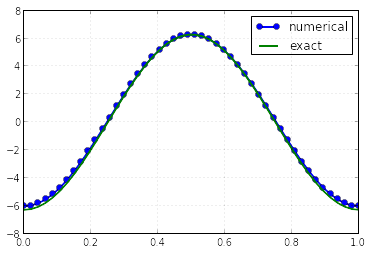

In [127]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# grid setup
Nx = 48
a, b = 0., 1.
x = np.linspace(a,b,Nx)

rho = 4*np.pi**2 * np.sin(2*np.pi * x) 
E = Gauss(rho,x)
E_exact = -2*np.pi*np.cos(2*np.pi*x)

plt.plot(x,E, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
plt.plot(x,E_exact, linewidth = 2, label = 'exact')
plt.hold('off')
plt.legend(loc = 'best')
plt.grid('on')

## D.3. Implementation and test case: non-periodic $\rho$ with $\langle \rho \rangle \neq 0$ and $\langle E \rangle \neq 0$

In this section, we apprehend a problem case where the above stepthrough does not directly give the solution. In graduated steps, we then make observations and discern logically how to fix the solution based on pure numerics for this particular example. After, we generalize our findings and put forth a general scheme that works for any density. The section concludes by coming full circle, that is, we identify the particular objects introduced in our efforts to "fix" the solution correspond to familiar terms that are known from the theory of ordinary differential equations (i.e. the solution decomposition above correspond to the particular and homogeneous solutions of the differential equation). This final section is important as it informs how to move forward from Gauss' law solvers to Poisson solvers.

We consider the following density to show how our solver fails in common situations:

$$\rho (x) = 4\pi^2\sin (2\pi x) + 2\pi x, \qquad \qquad x\in [0,1]$$

\begin{eqnarray*}
&& \\
\text{endpoints: } & \rho(0) = 0, & \rho (1) = 2\pi \\
\text{average: } & \langle \rho \rangle = \pi & \\
\end{eqnarray*}



then, since $\partial_xE(x) = \rho (x)$, we have the exact electric field given by

$$E (x) = -2\pi\cos (2\pi x) + \pi x^2 - 2\pi , \qquad \qquad x\in [0,1]$$

\begin{eqnarray*}
&& \\
\text{endpoints: } & E(0) = -4\pi \simeq -12.566, & E(1) = -3\pi \simeq -9.425 \\
\text{average: } & \langle E \rangle = -\frac{5\pi}{3} \simeq -5.236 & \\
\end{eqnarray*}

where we have chosen a constant of integration such that $E(\frac{1}{2}) = \pi/4$. Thus, we assess if the method can reproduce the solution $E$ given the equation:

$$\text{Test problem: } \qquad \frac{\partial E}{\partial x} = \rho (x) ,\quad x\in [0, 1]$$

where the charge density is defined just above. 

### D.3.1. Grid and exact solution setup

In [129]:
import numpy as np

# grid setup
Nx = 512
a, b = 0., 1.
x = np.linspace(a,b,Nx)
L = b - a
dx = L / (Nx - 1)

# charge density
rho = 4*np.pi**2 * np.sin(2*np.pi*x) + 2*np.pi*x
rho_avg = np.sum(rho)*dx / L

# exact electric field
E_exact = -2*np.pi * np.cos(2*np.pi * x) + np.pi*x**2 - 2*np.pi
E_avg = np.sum(E_exact)*dx / (b - a)

### D.3.2. Plots of exact charge density and electric field

We first show the charge distribution as mapped over a larger domain than $x\in [0, 1]$ to emphasize the function is clearly not periodic.

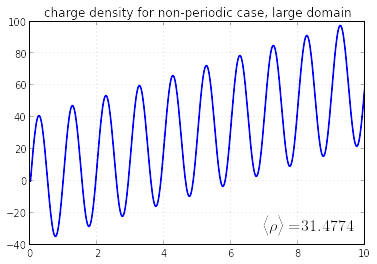

In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# grid setup
NX = 512
a, b = 0., 10.
X = np.linspace(a,b,Nx)
L = b - a
dX = L / (NX - 1)

# charge density
RHO = 4*np.pi**2 * np.sin(2*np.pi*X) + 2*np.pi*X
RHO_avg = np.sum(RHO)*dX / L

# plots
plt.plot(X,RHO, linewidth = 2)
plt.title('charge density for non-periodic case, large domain')
plt.text(9.75, -20, r'$\langle\rho\rangle = %g$' % RHO_avg, horizontalalignment = 'right', verticalalignment = 'top', fontsize = 16)
plt.grid('on')

The circumstance considered here is a perfect conductor at $x = 0$ (hence, $E(0) = 0$), and a charge collection plate at $x = 1$. By some perturbation we have at this moment the following charge density over $[0,1]$, where markers have been placed in the plot below at $x = 0$ and $x = 1$ to show the boundaries of the domain.

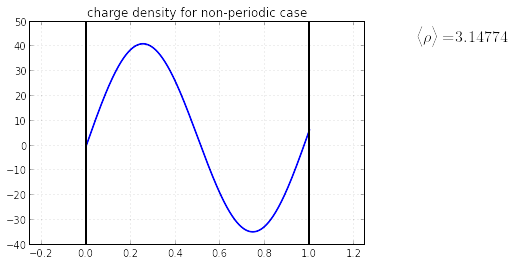

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x,rho, linewidth = 2)
plt.xlim([-0.25, 1.25])
plt.title('charge density for non-periodic case')
plt.axvline(x=0, ymin=-40, ymax = 50, linewidth=2, color='k')
plt.axvline(x=1, ymin=-40, ymax = 50, linewidth=2, color='k')
plt.text(1.9, 49, r'$\langle\rho\rangle = %g$' % rho_avg, horizontalalignment = 'right', verticalalignment = 'top', fontsize = 16)
plt.grid('on')

Again, the density is not periodic, thus $\rho (0) \neq \rho (1)$. In fact, $\rho (0) = 0.0, \rho (1) = 2\pi$. We attempt to solve this problem over the domain $x\in [0,1]$ in spite of the lack of periodicity to show how the solver fails. The exact solution for the electric field is given by

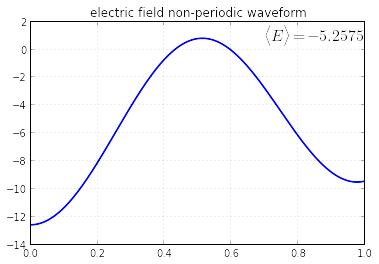

In [132]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(x,E_exact, linewidth = 2)
plt.title('electric field non-periodic waveform')
plt.text(1, 1.9, r'$\langle E \rangle = %g$' % E_avg, horizontalalignment = 'right', verticalalignment = 'top', fontsize = 16)
plt.grid('on')

### D.3.3. Numerical solution calculation and plots

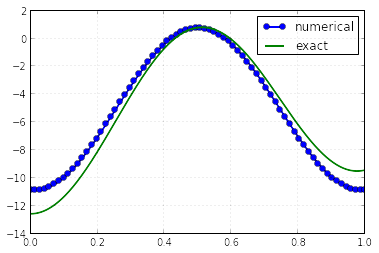

In [133]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# solution grid setup, xn
Nxn = 72
a, b = 0., 1.
dxn = (b - a) / (Nxn - 1)
xn = np.linspace(a,b,Nxn)

rho_n = 4*np.pi**2 * np.sin(2*np.pi*xn) + 2*np.pi*xn
E_tilde = Gauss(rho_n,xn)

E_total = E_tilde + E_avg
plt.plot(xn,E_total, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
plt.plot(x,E_exact, linewidth = 2, label = 'exact')
plt.hold('off')
plt.legend(loc = 'best')
plt.grid('on')

Since the function is not periodic, direct application of the Fourier solver produces an <b>incorrect</b> solution.

### D.3.4. Fixing the solution by zero padding and extending the domain

In [134]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# solution grid setup, xn
Nxn = 512
an, bn = -5., 6.
Ln = bn - an
dxn = Ln / (Nxn - 1)
xn = np.linspace(an,bn,Nxn)

# designate a nonzero domain, "interior"
interior_ind = np.where( (xn >= 0) & (xn <= 1))

rho_n = np.zeros(Nxn)
rho_n[interior_ind] = 4*np.pi**2 * np.sin(2*np.pi*xn[interior_ind]) + 2*np.pi*xn[interior_ind]
# rho_n already 0 outside of this domain

The density then takes the following form with zero padding in the extended domain $[-5,6]$.

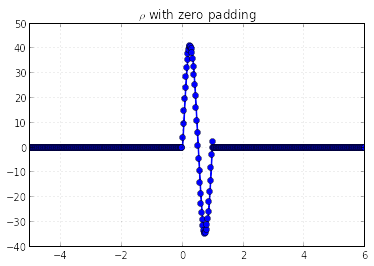

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(xn,rho_n, linewidth = 2, marker = 'o')
plt.title(r'$\rho$ with zero padding')
plt.xlim([-5,6])
plt.grid('on')

And, the numerical solution produces the following estimate for the fluctuating component $\tilde{E}_{ext}$ over the extended domain $[-5,6]$, where we plot the solution $\tilde{E}_{ext}$ alongside the exact solution $E_{exact}$ which only exists inside the domain $[0,1]$ along with relevant mean values for reference.

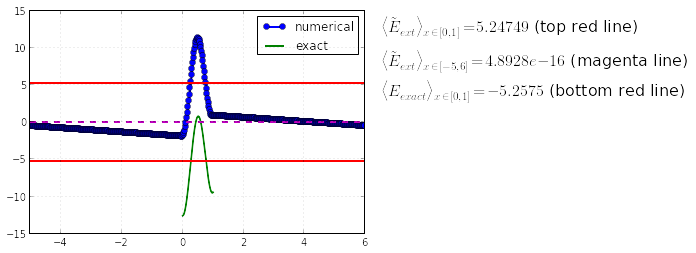

In [137]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

E_tilde_ext = Gauss(rho_n,xn) # the label n means "numerical"
E_tilde_ext_avg = np.sum(E_tilde_ext)*dxn / (bn - an)
E_tilde_int_avg = np.sum(E_tilde_ext[interior_ind])*dxn / (b - a)
E_avg_line = E_avg * np.ones(Nxn)
E_tilde_int_avg_line = E_tilde_int_avg * np.ones(Nxn)
E_tilde_ext_avg_line = E_tilde_ext_avg * np.ones(Nxn)

plt.plot(xn,E_tilde_ext, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
plt.plot(x,E_exact, linewidth = 2, label = 'exact')
plt.plot(xn, E_avg_line, color = 'r', linewidth = 2)
plt.plot(xn, E_tilde_int_avg_line, color = 'r', linewidth = 2)
plt.plot(xn, E_tilde_ext_avg_line, color = 'm', linestyle = '--',linewidth = 2)
plt.hold('off')
plt.legend(loc = 'best')
#plt.xlim([0,1])
plt.text(6.5, 14.5, r'$\langle \tilde{E}_{ext}\rangle_{x\in [0,1]}= %g$ (top red line)' % E_tilde_int_avg, horizontalalignment = 'left', verticalalignment = 'top', fontsize = 16)
plt.text(6.5, 10, r'$\langle \tilde{E}_{ext}\rangle_{x\in [-5,6]}= %g$ (magenta line)' % E_tilde_ext_avg, horizontalalignment = 'left', verticalalignment = 'top', fontsize = 16)
plt.text(6.5, 6, r'$\langle E_{exact}\rangle_{x\in [0,1]} = %g$ (bottom red line)' % E_avg, horizontalalignment = 'left', verticalalignment = 'top', fontsize = 16)
plt.xlim([-5,6])
plt.grid('on')

By visual inspection the plots appear to agree on the problem domain $[0,1]$, but in order to compare the two the numerical solution must be vertically shifted.

First, we note that of interest is a numerical solution $E$ defined inside the same problem domain $[0,1]$ as the exact solution $E_{exact}$. In the language of section D. we assemble the numerical solution as $E = \langle E \rangle + \tilde{E}$ over the problem domain $[0,1]$, where $\tilde{E}$ only differs from the true solution $E$ by a DC offset $\langle E \rangle$ (note: we presume we have knowledge of $\langle E \rangle$ given the problem context as finding this DC component is not the focus of this notebook). Thus, such an $\tilde{E}$ means that $\langle \tilde{E}\rangle_{x\in [0,1]} = 0$. But, it is clear that even if we restrict abscissa values to $x\in [0,1]$, $\tilde{E}_{ext}(x\in [0,1]) \neq \tilde{E}$ since $\langle\tilde{E}_{ext}\rangle_{x\in [0,1]} \neq 0$, but rather $\langle\tilde{E}_{ext}\rangle_{x\in [-5,6]} = 0$ by construction. Thus, if we wish to assemble the numerical solution as $E = \tilde{E} + \langle E \rangle$, we require constructing $\tilde{E}$ from the calculated $\tilde{E}_{ext}$. This is not complicated, but understanding the two quantities $\tilde{E}$ and $\tilde{E}_{ext}$ are not the same is necessary.

To find $\tilde{E}$, note that $\tilde{E}$ has zero mean on the problem domain. Thus, all that is needed is to shift $\tilde{E}_{ext}$ so that it has zero mean on this same interval. That is, we pursue a mapping so that

$$\tilde{E}_{ext} \mapsto \hat{\tilde{E}}_{ext} \colon \langle \hat{\tilde{E}}_{ext}\rangle_{x\in [0,1]} = 0$$

that is,

$$\hat{\tilde{E}}_{ext} = \tilde{E}_{ext} - \langle \tilde{E}_{ext}\rangle_{x\in [0,1]}$$

since

\begin{eqnarray*}
\langle \hat{\tilde{E}} \rangle_{x\in [0,1]} & = & \langle [ \tilde{E} - \langle \tilde{E} \rangle_{x\in [0,1]} ]\rangle_{x\in [0,1]} \\
& = & \langle\tilde{E}\rangle_{x\in [0,1]} - \langle \langle \tilde{E}\rangle_{x\in [0,1]} \rangle_{x\in [0,1]} \\
& = & \langle\tilde{E}\rangle_{x\in [0,1]} - \langle\tilde{E}\rangle_{x\in [0,1]} \\
&&\\
\langle \hat{\tilde{E}}\rangle_{x\in [0,1]}  & = & 0
\end{eqnarray*}

This produces an $\hat{\tilde{E}}$ that is equal to $\tilde{E}$ on the problem domain, i.e. the definition of $\tilde{E}$ is then seen to be,

$$\tilde{E}(x) = \begin{cases}
\hat{\tilde{E}}_{ext}(x) & 0 \leq x \leq 1 \\
& \\
0 & \text{else}
\end{cases}
$$

Below we plot the function $\hat{\tilde{E}}_{ext}$ over the whole extended domain $[-5,6]$ for direct comparison with $\tilde{E}_{ext}$ in the the above plot.

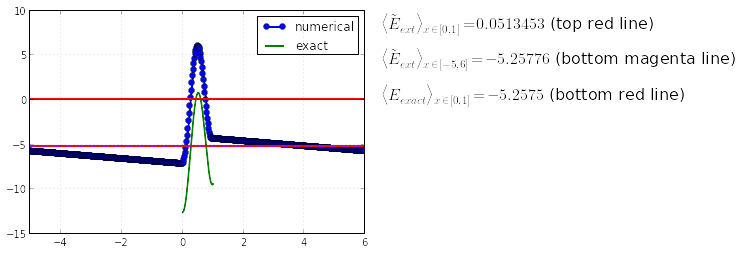

In [138]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

E_tilde_hat_ext = E_tilde_ext - E_tilde_int_avg

E_tilde_hat_ext_avg = np.sum(E_tilde_hat_ext)*dxn / (bn - an)
E_tilde_hat_int_avg = np.sum(E_tilde_hat_ext[interior_ind])*dxn / (b - a)

E_tilde_hat_ext_avg_line = E_tilde_hat_ext_avg * np.ones(Nxn)
E_tilde_hat_int_avg_line = E_tilde_hat_int_avg * np.ones(Nxn)

plt.plot(xn,E_tilde_hat_ext, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
plt.plot(x,E_exact, linewidth = 2, label = 'exact')
plt.plot(xn, E_avg_line, color = 'r', linewidth = 2)
plt.plot(xn, E_tilde_hat_int_avg_line, color = 'r', linewidth = 2)
plt.plot(xn, E_tilde_hat_ext_avg_line, color = 'm', linestyle = '--',linewidth = 2)
plt.hold('off')
plt.legend(loc = 'best')
plt.text(6.5, 10, r'$\langle \tilde{E}_{ext}\rangle_{x\in [0,1]}= %g$ (top red line)' % E_tilde_hat_int_avg, horizontalalignment = 'left', verticalalignment = 'top', fontsize = 16)
plt.text(6.5, 6, r'$\langle \tilde{E}_{ext}\rangle_{x\in [-5,6]}= %g$ (bottom magenta line)' % E_tilde_hat_ext_avg, horizontalalignment = 'left', verticalalignment = 'top', fontsize = 16)
plt.text(6.5, 2, r'$\langle E_{exact}\rangle_{x\in [0,1]} = %g$ (bottom red line)' % E_avg, horizontalalignment = 'left', verticalalignment = 'top', fontsize = 16)
plt.xlim([-5,6])
plt.grid('on')

Now, that $\tilde{E}$ has been obtained, we can find the total solution as usual in the domain $[0,1]$: $E = \tilde{E} + \langle E \rangle$, where $\langle E \rangle$ is taken to be known by some means since Fourier methods cannot give information about it (here, we just use $E_{exact} \simeq -5.2575$). Finally then, we have the total solution:

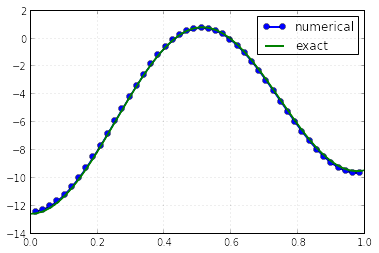

In [139]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

E_tilde = E_tilde_hat_ext[interior_ind]
E_total = E_tilde + E_avg 
plt.plot(xn[interior_ind], E_total, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
plt.plot(x,E_exact, linewidth = 2, label = 'exact')
plt.legend(loc = 'best')
plt.grid('on')

Note that even though 512 grid points were used over the domain $[-5,6]$, in the problem domain $[0,1]$, we only have

In [140]:
print len(interior_ind[0])

46


grid points in the solution domain. The signed error $ = E(x) - E_{exact}(x)$ is

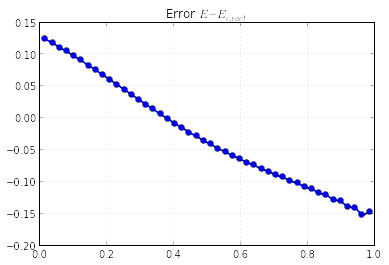

In [141]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

E_exact = -2*np.pi * np.cos(2*np.pi * xn[interior_ind]) + np.pi*xn[interior_ind]**2 - 2*np.pi

error = (E_total - E_exact)

plt.plot(xn[interior_ind], error, linewidth = 2, marker = 'o')
plt.title('Error $E - E_{exact}$')
plt.grid('on')

We plot several solutions for different mesh resolutions to show the fidelity of the method (which permit more frequency components to be included given the increased sampling). To understand the effect of "sampling" (different grid resolutions) on the Fourier solution, we expand the plot window a bit to see what is going on in the full picture.

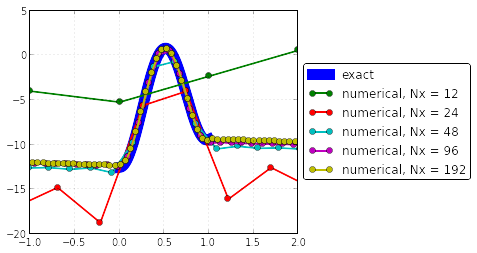

In [142]:
%matplotlib inline
import matplotlib.pyplot as plt

E_exact = -2*np.pi * np.cos(2*np.pi * x) + np.pi*x**2 - 2*np.pi

fig, ax = plt.figure(), plt.subplot(111)
ax.plot(x, E_exact, linewidth = 11, label = 'exact')
an, bn = -5., 6.
Nxn = 12
NumGrids = 5

for m in range(NumGrids):
    
    # solution grid setup, xn
    dxn = (bn - an) / (Nxn - 1)
    xn = np.linspace(an,bn,Nxn)

    # designate a nonzero domain, "interior"
    interior_ind = np.where( (xn >= 0) & (xn <= 1))
    rho_n = np.zeros(Nxn)
    rho_n[interior_ind] = 4*np.pi**2 * np.sin(2*np.pi*xn[interior_ind]) + 2*np.pi*xn[interior_ind]

    E_tilde_ext = Gauss(rho_n,xn)
    E_tilde_int_avg = np.sum(E_tilde_ext[interior_ind]) * dxn / (b - a)
    E_tilde_hat = E_tilde_ext - E_tilde_int_avg
    E_total = E_tilde_hat + E_avg
    ax.plot(xn,E_total, linewidth = 2, marker = 'o', label = 'numerical, Nx = %d' % Nxn)
    Nxn *= 2
    
    
ax.hold('off')

frame = ax.get_position() # position of plot center

# shrink frame of the plot to make room for a legend on the right side
ax.set_position([frame.x0, frame.y0, 
                 frame.width * 0.8, frame.height])

# Place legend to the right of the shrunken frame
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, ncol=1)

plt.xlim([-1,2])
plt.grid('on')

(the blue 'exact' solution does not actually dip appreciably below the yellow numerical solution as it appears. In order to have the blue line be seen an enormous line thickness was used, this is an artifice of that).

Plotting the errors:

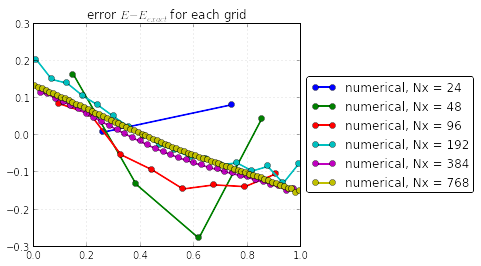

In [143]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.figure(), plt.subplot(111)

an, bn = -5., 6.
Nxn = 24
NumGrids = 6

for m in range(NumGrids):
    
    # solution grid setup, xn
    dxn = (bn - an) / (Nxn - 1)
    xn = np.linspace(an,bn,Nxn)

    # designate a nonzero domain, "interior"
    interior_ind = np.where( (xn >= 0) & (xn <= 1))
    rho_n = np.zeros(Nxn)
    rho_n[interior_ind] = 4*np.pi**2 * np.sin(2*np.pi*xn[interior_ind]) + 2*np.pi*xn[interior_ind]

    E_tilde_ext = Gauss(rho_n,xn)
    E_tilde_int_avg = np.sum(E_tilde_ext[interior_ind]) * dxn / (b - a)
    E_tilde_hat = E_tilde_ext - E_tilde_int_avg
    E_total_ext = E_tilde_hat + E_avg
    E_total = E_total_ext[interior_ind]
    
    E_exact = -2*np.pi * np.cos(2*np.pi * xn[interior_ind]) + np.pi*xn[interior_ind]**2 - 2*np.pi
    x_int = xn[interior_ind]
    error = (E_total - E_exact)
    ax.plot(x_int, error, linewidth = 2, marker = 'o', label = 'numerical, Nx = %d' % Nxn)
    ax.hold('on')
    Nxn *= 2
    
    
ax.hold('off')


frame = ax.get_position() # position of plot center

# shrink frame of the plot to make room for a legend on the right side
ax.set_position([frame.x0, frame.y0, 
                 frame.width * 0.8, frame.height])

# Place legend to the right of the shrunken frame
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, ncol=1)
plt.title('error $E - E_{exact}$ for each grid')
plt.grid('on')

$N_x = 12$ grid solution error not shown above as it much larger than the the above, see previous plot to get a sense of the point-wise error ($\sim 7$ across the board) forcing our plot window to be too large to see the differences in the grids for $N_x \geq 24$.

Thus, zero-padding appears to work as theory already informed. That is, while Fourier methods only work on periodic functions, it can be proven for a larger class of non-periodic functions (such as that above) that it can perform well. In particular, if a restricted domain is of interest we can define a period outside of the compact nonzero density and establish a large enough "period" so that the function has a convergent trigonometric (Fourier) series. It is known that for non-periodic functions of this class that are periodized in this manner, a greater the number of Fourier modes needs to be included in order to accurately estimate the function as a Fourier series. In particular, for such functions it is well-known that the Fourier series tends to a Fourier integral (an infinite number of wave frequencies needs to be included to represent the function).

### D.3.5. Reducing the size of the domain extension

In practice, the idea of extending the domain in order to compute accurate solutions for an interior domain presents a challenge to numerical efficacy. We would like to reduce the size of this extension in order to limit computaitonal expense. Hence, we take a first pass at investigating how small we can contract the extended domain to produce reasonable solutions for the model case of this section D.3.

We choose $N_x = 192$ as a grid and examine the solutions over domains that begin the same size as the problem domain $[0,1]$ and then for each subsquent plot we expand the left and right sides of the domain each by 0.5 each step.

### Numerical solutions

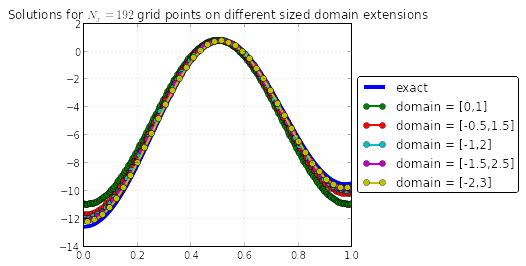

In [151]:
%matplotlib inline
import matplotlib.pyplot as plt

E_exact = -2*np.pi * np.cos(2*np.pi * x) + np.pi*x**2 - 2*np.pi

fig, ax = plt.figure(), plt.subplot(111)
ax.plot(x, E_exact, linewidth = 4, label = 'exact')
an, bn = 0.,1.
Nxn = 192
NumGrids = 5

for m in range(NumGrids):
    
    # solution grid setup, xn
    dxn = (bn - an) / (Nxn - 1)
    xn = np.linspace(an,bn,Nxn)

    # designate a nonzero domain, "interior"
    interior_ind = np.where( (xn >= 0) & (xn <= 1))
    rho_n = np.zeros(Nxn)
    rho_n[interior_ind] = 4*np.pi**2 * np.sin(2*np.pi*xn[interior_ind]) + 2*np.pi*xn[interior_ind]

    E_tilde_ext = Gauss(rho_n,xn)
    E_tilde_int_avg = np.sum(E_tilde_ext[interior_ind]) * dxn / (b - a)
    E_tilde_hat = E_tilde_ext - E_tilde_int_avg
    E_total = E_tilde_hat + E_avg
    ax.plot(xn,E_total, linewidth = 2, marker = 'o', label = 'domain = [%g,%g]' % (an,bn))
    an -= 0.5
    bn += 0.5
    
    
ax.hold('off')


frame = ax.get_position() # position of plot center

# shrink frame of the plot to make room for a legend on the right side
ax.set_position([frame.x0, frame.y0, 
                 frame.width * 0.8, frame.height])

# Place legend to the right of the shrunken frame
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, ncol=1)

plt.title('Solutions for $N_x = 192$ grid points on different sized domain extensions')
plt.xlim([0,1])
plt.grid('on')

### Numerical errors $E - E_{exact}$

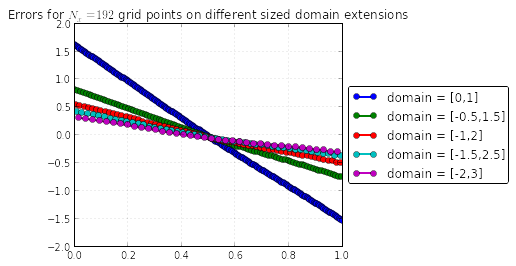

In [156]:
%matplotlib inline
import matplotlib.pyplot as plt

E_exact = -2*np.pi * np.cos(2*np.pi * x) + np.pi*x**2 - 2*np.pi

fig, ax = plt.figure(), plt.subplot(111)
an, bn = 0.,1.
Nxn = 192
NumGrids = 5

for m in range(NumGrids):
    
    # solution grid setup, xn
    dxn = (bn - an) / (Nxn - 1)
    xn = np.linspace(an,bn,Nxn)

    # designate a nonzero domain, "interior"
    interior_ind = np.where( (xn >= 0) & (xn <= 1))
    rho_n = np.zeros(Nxn)
    rho_n[interior_ind] = 4*np.pi**2 * np.sin(2*np.pi*xn[interior_ind]) + 2*np.pi*xn[interior_ind]

    E_tilde_ext = Gauss(rho_n,xn)
    E_tilde_int_avg = np.sum(E_tilde_ext[interior_ind]) * dxn / (b - a)
    E_tilde_hat = E_tilde_ext - E_tilde_int_avg
    E_total = E_tilde_hat + E_avg
    
    # exact solution recomputation for point-wise matching in an error calculation
    x_int = xn[interior_ind]
    E_exact = -2*np.pi * np.cos(2*np.pi * x_int) + np.pi*x_int**2 - 2*np.pi
    error = (E_total[interior_ind] - E_exact)
    ax.plot(x_int, error, linewidth = 2, marker = 'o', label = 'domain = [%g,%g]' % (an,bn))
    ax.hold('on')
    an -= 0.5
    bn += 0.5
    
    
ax.hold('off')


frame = ax.get_position() # position of plot center

# shrink frame of the plot to make room for a legend on the right side
ax.set_position([frame.x0, frame.y0, 
                 frame.width * 0.8, frame.height])

# Place legend to the right of the shrunken frame
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, ncol=1)

plt.title('Errors for $N_x = 192$ grid points on different sized domain extensions')
plt.xlim([0,1])
plt.grid('on')

Thus, the larger the extension the smaller the errors. We note the errors are largest near the edges which present challenges for the boundary values to be met that are not periodic. We are now in a position to present a concise algorithm for non-periodic densities.

## D.4. General algorithm for non-periodic densities

The problem domain for $\partial_x E = \rho$ is $\mathcal{D}_x\in [a,b]$.

<ol>
<li> Compute the wave number vector $\underline{\xi}$, where the $k$th wave number is given by:
$${}$$
$$ \xi_k =
  \begin{cases}
   2\pi k / L & \text{if } k \leq N_x/2 \\[0.5em]
   2\pi (k - N_x) / L       & \text{else}
  \end{cases}$$
$${}$$
Note, this computation recognizes that second half of the wave numbers are equal to the negative wave numbers.

<li> Given the charge density $\rho$ is known (or calculable), but non-periodic, define an extended domain $\mathcal{D}_{\mathcal{X}} \supset \mathcal{D}_x$ for zero-padding (i.e. choose $\mathcal{D}_{\mathcal{X}} = [A,B]$, where $A < a$, $B > b$). Thus, we extend the function $\rho \mapsto \rho_{ext}$, where
${}$
$$\rho_{ext} = \begin{cases}
\rho (x) & x\in\mathcal{D}_{\mathcal{X}}\cap\mathcal{D}_x \\
& \\
0 & x\in \mathcal{D}_{\mathcal{X}}\backslash\mathcal{D}_x
\end{cases}
$$
${}$


<li> Compute the discrete Fourier transform of $\rho_{ext}$, e.g. by a fast Fourier transform algorithm,
$${}$$
$$\text{FFT}[\underline{\rho}_{ext}] = (\text{FFT}[\rho_{ext}](0), \text{FFT}[\rho_{ext}](1), \text{FFT}[\rho_{ext}](2), \ldots , \text{FFT}[\rho_{ext}](N_x - 1)) = \left(\text{FFT}[\rho_{ext}](\ell )\right)_{\ell = 0}^{N_x - 1}$$
$${}$$

<li> Find the discrete Fourier transform of the fluctuating field component $E_{ext}$, $\text{FFT}[\underline{\tilde{E}}_{ext}]$, from eqs. (2), (3):
$${}$$
$$\text{FFT}[\underline{\tilde{E}}_{ext}] = \left[0, \left(\frac{\text{FFT}[\rho_{ext}](\ell )}{\text{i}\xi_k}\right)_{\ell = k = 1}^{N_x - 1}\right]= \left(0, \frac{\text{FFT}[\rho_{ext}](1)}{\text{i}\xi_0}, \frac{\text{FFT}[\rho_{ext}](1)}{\text{i}\xi_1}, \frac{\text{FFT}[\rho_{ext}](2)}{\text{i}\xi_2} , \ldots , \frac{\text{FFT}[\rho_{ext}](N_x-1)}{\text{i}\xi_{N_x -1}} \right)$$
$${}$$
where the $\ell$th component of $\text{FFT}[\underline{\tilde{\rho}}]$ must correspond to the $k$th Fourier wave number. If using a library module to compute an FFT, this may require reviewing the associated documentation to understand the organization of returned FFT vectors, so it is understood which vector entry corresponds to which wave number, e.g. in numpy.fft we consult [2] (the wave number vector computed in step (1) is in the same order as the vector returned by numpy.fft.fft)

Note, in NumPy arrays, a vectorized computation of this does not require looping and can be done by numpy division of two arrays.


<li> Find the fluctuating (extended) electric field in real space by taking the IFFT of the vector computed in step (3):  per eq. (1)
$${}$$
$$\underline{\tilde{E}}_{ext}(t^n,\underline{x}) = \text{IFFT}[\text{FFT}[\underline{\tilde{E}}_{ext}]] \qquad \qquad (1, \text{revisited})$$
$${}$$

<li>Construct the solution $\tilde{E}$ inside the problem domain $\mathcal{D}_x \subset \mathcal{D}_{\mathcal{X}}$, defined as

$$\tilde{E}(x) = \begin{cases}
\tilde{E}_{ext} - \langle E \rangle_{x\in\mathcal{D}_x} & x\in\mathcal{D}_x \\
& \\
0 & \text{else}
\end{cases}
$$

where $\langle \cdot \rangle_{x\in\mathcal{D}_x}$ corresponds to the average value over the problem domain $\mathcal{D}_x$. Discretely, we compute the vector $\underline{\tilde{E}}$ in one step:

$$\tilde{E}_i = \tilde{E}_{ext,i} - \frac{\sum_{i : x_i\in\mathcal{D}_x} \Delta x E_i}{|\mathcal{D}_x|}, \qquad |\mathcal{D}_x| = \sum_{i : x_i\in\mathcal{D}_x} \Delta x, \qquad \forall i\in\mathcal{D}_{\mathcal{x}}$$ 

Note, that we do not need to operate on gridpoints outside of $\mathcal{D}_x$ to store this vector.

<li> Provided we know or can calculate the average field $\langle E \rangle$, the total field is then $\underline{E}(t^n, \underline{x}) = \langle \underline{E}(t^n, \underline{x})\rangle + \underline{\tilde{E}}(t^n,\underline{x})$

</ol>


## D.5 Reinterpretation of solution

In the above, we partitioned the solution as

$$E = \tilde{E} + \langle E \rangle$$

based on observations that the Fourier solution gives all harmonics except the DC component $k = 0$, thus we appended this component as $\langle E \rangle$ afterward (where we know the average value of the field by some extra means, e.g. we apply a constant external electric field).

Examining, the differential equation, we can fit the above decomposition into the general theory of ordinary differential equations. That is, for a <i>linear</i> differential equation such as

$$\partial_x E  = \rho $$

the solution is expressible in terms of two parts:

$$E = E_p + E_h$$

where $E_p$ is the particular solution and $E_h$ is the homogeneous solution, that is, it is the solution to 

\begin{eqnarray*}
\partial_x E_h & = & 0\\
&&\\
E_h & = & A, \qquad A = \text{constant}
\end{eqnarray*}

thus, the solution is

$$E(x) = E_p(x) + A$$

Matching this with above, we see that $E_p = \tilde{E}$, and $A = \langle E \rangle$. <b>The Fourier solution $\tilde{E}$ corresponds to the particular solution and the DC offset $\langle E \rangle$ corresponds to the homogeneous solution</b>. Even if this differs, it can only differ by a constant given the form above is too restrictive to allow for other possibilities. That is, even if $E_p \neq \tilde{E}$, it must be the case that $DE_p = \tilde{E}$, and there always exists a factorization such that $DE(x) = DE_p(X) + DA$ or $E(x) = \tilde{E} + A$ where $A$ the constant $D$ has been absorbed in $A$.

# E. Poisson's equation solver

We consider the equation:

$$\frac{\partial^2 \phi}{\partial x^2} = \rho$$

Where the right-hand side is casted as a charge density $\rho$ as in section D. From eq. (1), we note that $E = -\partial_x \phi$ indicates

$$\underline{\partial_x\tilde{\phi}}(t^n,\underline{x}) = \text{IFFT}[\text{FFT}[\underline{\partial_x\tilde{\phi}}] ] \qquad \qquad (1, \text{adapted})$$

and, from eqs. (2), (3), we have the definitions

$$\text{FFT}[\underline{\partial_x\tilde{\phi}}] = -\left\{ \left[0, \left(\frac{\text{FFT}[\rho ](k)}{\text{i}\xi_k}\right)_{k = 1}^{N_x - 1}\right]\right\} \qquad \qquad (2, \text{revisited})$$

$$\left[0, \left(\frac{\text{FFT}[\rho ]_k}{\text{i}\xi_k}\right)_{k = 1}^{N_x - 1}\right]= \left(0, \frac{\text{FFT}[\rho ](1)}{\text{i}\xi_0}, \frac{\text{FFT}[\rho ](2)}{\text{i}\xi_1}, \frac{\text{FFT}[\rho ](3)}{\text{i}\xi_2} , \ldots , \frac{\text{FFT}[\rho ](N_x-1)}{\text{i}\xi_{N_x -1}} \right), \qquad (3, \text{revisited})$$

It is clear from eq. $(*)$ in section D that integrating once more involves one more division by $\text{i}\xi_k$, so that the following is clear:

$$\underline{\tilde{\phi}} = \text{IFFT} [\text{FFT}[\underline{\tilde{\phi}}] \qquad \qquad (4)$$

for

$$\text{FFT}[\underline{\tilde{\phi}}] = \left\{ \left[0, \left(\frac{\text{FFT}[\rho ](k)}{\xi^2_k}\right)_{k = 1}^{N_x - 1}\right] \right\}  \qquad \qquad (5)$$

where the factor $i^2 = -1$ produces an overall positive right-hand side, and

$$\left[0, \left(\frac{\text{FFT}[\rho ]_k}{\xi^2_k}\right)_{k = 1}^{N_x - 1}\right]= \left(0, \frac{\text{FFT}[\rho ](1)}{\xi^2_0}, \frac{\text{FFT}[\rho ](2)}{\xi^2_1}, \frac{\text{FFT}[\rho ](3)}{\xi^2_2} , \ldots , \frac{\text{FFT}[\rho ](N_x-1)}{\xi^2_{N_x -1}} \right), \qquad (6)$$

The total solution is known to be

$$\phi = \phi_p + \phi_h$$

where $\phi_p$ and $\phi_h$ are the particular and homogeneous solutions, respectively. The homogeneous solution is the solution to

\begin{eqnarray*}
\partial_x^2\phi_h & = & 0 \\
&&\\
\phi_h & = & Bx + C, \qquad B,C = \text{constant}
\end{eqnarray*}

As before, $\phi_p$ must correspond to the fluctuating component $\tilde{\phi}$. Combining this with the above we have

$$\phi = \tilde{\phi} + Bx + C$$

To find the constants, we can consider two means. The first is to consider the derivative:

$$\partial_x\phi = \partial_x\tilde{\phi} + B$$

by definition, $\langle \tilde{Q}\rangle = 0$ for any quantity $Q$. Averaging the above:

\begin{eqnarray*}
\langle \partial_x\phi \rangle & = & \underbrace{\langle \partial_x\tilde{\phi}\rangle}_{=\, 0} + B\langle 1 \rangle \\
&&\\
B & = & \langle \partial_x\phi \rangle = -\langle E \rangle
\end{eqnarray*}

Up to this point, we have

$$\phi = \tilde{\phi} - \langle E \rangle x + C$$

to find the remaining point, we can use any boundary condition, say at $x = \xi$, $\phi (x = \xi ) = \phi(\xi )$:

\begin{eqnarray*}
\phi (\xi ) & = & \tilde{\phi}(\xi ) - \langle E \rangle (\xi) + C \\
&&\\
C & = & \phi (\xi ) - \tilde{\phi}(\xi ) + \langle E \rangle (\xi )\\
\end{eqnarray*}

Collecting the results, the total solution is finally,

$$\boxed{\phi (x) = (\tilde{\phi}(x) - \tilde{\phi}(\xi )) - \langle E \rangle (x - \xi ) + \phi (\xi )}$$

Where the value of $\tilde{\phi}$ at $x = \xi$ can be obtained from the obtained Fourier numerical solution.

Alternatively, we can consider the total solution and apply both boundary conditions at the domain endpoints $x = \eta$ and $x = \xi$ and simultaneously solve for the constants $B$ and $C$ below:

\begin{eqnarray*}
\phi (\eta ) & = & \tilde{\phi}(\eta ) + B\eta + C \\
&&\\
\phi (\xi ) & = & \tilde{\phi}(\xi ) + B\xi  + C \\
\end{eqnarray*}

Solving the first for $C$:

\begin{eqnarray*}
\phi (\eta ) & = & \tilde{\phi}(\eta ) + B\eta + C \\
&& \\
C & = & \phi (\eta ) - \tilde{\phi}(\eta ) - B\eta
\end{eqnarray*}

Inserting this into the second equation above

\begin{eqnarray*}
\phi (\xi ) & = & \tilde{\phi}(\xi ) + B\xi  + C \\
&& \\
\phi (\xi ) & = & \tilde{\phi}(\xi ) + B\xi + \phi (\eta ) - \tilde{\phi}(\eta ) - B\eta \\
&& 
\end{eqnarray*}


$$\boxed{B  =  \frac{(\phi (\xi ) - \phi (\eta )) - (\tilde{\phi}(\xi ) - \tilde{\phi}(\eta ))}{\xi - \eta}}$$

Back substituting this into $C$ above,

\begin{eqnarray*}
C & = & \phi (\eta ) - \tilde{\phi}(\eta ) - B\eta  \\
& & \\
& = & \phi (\eta ) - \tilde{\phi}(\eta ) - \eta \frac{(\phi (\xi ) - \phi (\eta )) - (\tilde{\phi}(\xi ) - \tilde{\phi}(\eta ))}{\xi - \eta} \\
&& 
\end{eqnarray*}

$$\boxed{C = \left(1 + \frac{\eta}{\xi - \eta}\right)\phi (\eta ) - \left(1 + \frac{\eta}{\xi - \eta}\right)\tilde{\phi}(\eta ) - \frac{\eta}{\xi - \eta}(\phi (\xi ) - \tilde{\phi}(\xi ))}$$

or,

$$\boxed{\phi (x) = \tilde{\phi}(x) + \left[\frac{(\phi (\xi ) - \phi (\eta )) - (\tilde{\phi}(\xi ) - \tilde{\phi}(\eta ))}{\xi - \eta}\right] x + \left[\left(1 + \frac{\eta}{\xi - \eta}\right)\phi (\eta ) - \left(1 + \frac{\eta}{\xi - \eta}\right)\tilde{\phi}(\eta ) - \frac{\eta}{\xi - \eta}(\phi (\xi ) - \tilde{\phi}(\xi )) \right]}$$

## E.1.a. General algorithm

<ol>
<li> Compute the wave number vector $\underline{\xi}$, where the $k$th wave number is given by:
$${}$$
$$ \xi_k =
  \begin{cases}
   2\pi k / L & \text{if } k \leq N_x/2 \\[0.5em]
   2\pi (k - N_x) / L       & \text{else}
  \end{cases}$$
$${}$$
Note, this computation recognizes that second half of the wave numbers are equal to the negative wave numbers.

<li> Compute the discrete Fourier transform of the charge density $\rho$, e.g. by a fast Fourier transform algorithm,
$${}$$
$$\text{FFT}[\underline{\rho}] = (\text{FFT}[\rho](0), \text{FFT}[\rho](1), \text{FFT}[\rho](2), \ldots , \text{FFT}[\rho](N_x - 1)) = \left(\text{FFT}[\rho](\ell )\right)_{\ell = 0}^{N_x - 1}$$
$${}$$

Note, for our Vlasov-Poisson model case we consider singly charged ions of uniform background density $n_0 = \text{constant}$, and in our normalized units (charges = $\pm 1$) we can calculate $\rho_i = n_0 - \sum_{j = 0}^{N_v - 1} \Delta v_j f^n_{i,j}$, where $f^n_{i,j} = f(t^n, x_i, v_j)$ with velocity space grid spacing $\Delta v_j$.

<li> If the derivative $\underline{\partial_x\tilde{\phi}}$ is desired, compute per eqs. (2), (3):
$${}$$
$$\text{FFT}[\underline{\partial_x\tilde{\phi}}] = -\left[0, \left(\frac{\text{FFT}[\rho](\ell )}{\text{i}\xi_k}\right)_{\ell = k = 1}^{N_x - 1}\right]= -\left(0, \frac{\text{FFT}[\rho](1)}{\text{i}\xi_0}, \frac{\text{FFT}[\rho](1)}{\text{i}\xi_1}, \frac{\text{FFT}[\rho](2)}{\text{i}\xi_2} , \ldots , \frac{\text{FFT}[\rho](N_x-1)}{\text{i}\xi_{N_x -1}} \right) \, (2,3 \text{ revisited})$$
$${}$$

If the fluctuating potential $\tilde{\phi}$ is desired, compute the discrete Fourier transforms per eqs. (5), (6):

$$\text{FFT}[\underline{\tilde{\phi}}] = \left[0, \left(\frac{\text{FFT}[\rho ](k)}{\xi^2_k}\right)_{k = 1}^{N_x - 1}\right] = \left(0, \frac{\text{FFT}[\rho ](1)}{\xi^2_0}, \frac{\text{FFT}[\rho ](2)}{\xi^2_1}, \frac{\text{FFT}[\rho ](3)}{\xi^2_2} , \ldots , \frac{\text{FFT}[\rho ](N_x-1)}{\xi^2_{N_x -1}} \right), \, (5,6)$$

where the $\ell$th component $\text{FFT}[\rho](\ell )$ must correspond to the $k$th Fourier wave number $\xi_k$. If using a library module to compute an FFT, this may require reviewing the associated documentation to understand the organization of returned FFT vectors, so it is understood which vector entry corresponds to which wave number, e.g. in numpy.fft we consult [2] (the wave number vector computed in step (1) is in the same order as the vector returned by numpy.fft.fft)

Note, in NumPy arrays, a vectorized computation of this does not require looping and can be done by numpy division of two arrays.


<li> Find the fluctuating derivative of the potential if desired per eq. (1):
$${}$$
$$\underline{\partial_x\tilde{\phi}}(t^n,\underline{x}) = \text{IFFT}[\text{FFT}[\underline{\tilde{E}}]] \qquad \qquad (1, \text{revisited})$$
$${}$$

and/or, find the fluctating potential itself per eq. (4):

$$\underline{\tilde{\phi}} = \text{IFFT} [\text{FFT}[\underline{\tilde{\phi}}]$$

<li> Assemble the total derivative of the potential:
$${}$$
$$\underline{\partial_x\phi}(t^n, \underline{x}) = \langle \underline{\partial_x\phi}\rangle + \underline{\partial_x\tilde{\phi}}(t^n,\underline{x}) = -\langle\underline{E}\rangle + \underline{\partial_x\tilde{\phi}}(t^n,\underline{x})$$
$${}$$
For an energy conservative plasma, we have $\langle E \rangle = \langle \partial_x\phi \rangle = 0$ so that $\underline{\partial_x\phi} = \underline{\partial_x\tilde{\phi}}$.
$${}$$
if needed, assemble the total potential, either by 

$$\phi (x) = \tilde{\phi}(x) + \left[\frac{(\phi (\xi ) - \phi (\eta )) - (\tilde{\phi}(\xi ) - \tilde{\phi}(\eta ))}{\xi - \eta}\right] x + \left[\left(1 + \frac{\eta}{\xi - \eta}\right)\phi (\eta ) - \left(1 + \frac{\eta}{\xi - \eta}\right)\tilde{\phi}(\eta ) - \frac{\eta}{\xi - \eta}(\phi (\xi ) - \tilde{\phi}(\xi )) \right] \,\,\,\,\,\text{(E.1)}$$

or, equivalently as

$$\phi (x) = (\tilde{\phi}(x) - \tilde{\phi}(\xi )) - \langle E \rangle (x - \xi ) + \phi (\xi )\qquad \qquad \text{(E.2)}$$

where $\xi$ and $\eta$ are endpoints of the problem domain. The function evaluations of $\tilde{\phi}$ can be obtained from the solution obtained in the previous steps, and the boundary values themselves in a problem context are assumed to be known $\phi (\xi)$ and $\phi (\eta )$.
</ol>


## E.1.b. Poisson solver: Poisson.py

(python file located in /pyfiles/)

In [3]:
import numpy as np

def Poisson(rho, x, return_phi = 'yes', return_dphi = 'no'):
    """Computes self-consistent potential phi and/or dphi by 
    solving Poisson's eq.using FFT/IFFT.

    inputs:
    rho -- (ndarray, ndim = 1)  charge density vector,
    x -- (ndarrya, ndim = 1) configurational variable

    outputs:
    phi and/or dphi -- (ndarray,dim=1) electric field, E(x) at time t^n
    """
    Nx = len(x)
    L = np.max(x) - np.min(x)
    dx = L / (Nx - 1)
    
    # create wave number vector in same order as return of numpy.fft.fft
    xi = np.zeros(Nx)
    xi[0:Nx/2 + 1] = 2 * np.pi * np.arange(Nx/2 + 1) / L
    xi[Nx/2 + 1:] = 2 * np.pi * (np.arange(Nx/2 + 1, Nx) - Nx) / L

    # Fluctuating dphi  in Fourier space, Fdphi_tilde[0] = 0 already
    Frho_tilde = np.fft.fft(rho)
    
    if return_dphi.lower() == 'yes':
        Fdphi_tilde = np.zeros(Nx, dtype = complex)
        Fdphi_tilde[1:Nx] = -Frho_tilde[1:Nx] / (1j * xi[1:Nx])
        dphi_tilde = np.real(np.fft.ifft(Fdphi_tilde))
    
    if return_phi.lower() == 'yes':
        Fphi_tilde = np.zeros(Nx, dtype = complex)
        Fphi_tilde[1:Nx] =  Frho_tilde[1:Nx] / (xi[1:Nx]) ** 2
        phi_tilde = np.real(np.fft.ifft(Fphi_tilde))
    
    if return_dphi.lower() == 'yes' and return_phi.lower() == 'yes':
        return dphi_tilde, phi_tilde
    
    elif return_dphi.lower() != 'yes' and return_phi.lower() == 'yes':
        return phi_tilde
    
    elif return_dphi.lower() == 'yes' and return_phi.lower() != 'yes':
        return dphi_tilde

## E.2. Implementation and test case: periodic $\rho$ with $\langle\rho\rangle = \langle E \rangle = 0$
### (compare with section D.2.)

We consider the solution to Poisson's equation:

$$\partial_x^2\phi = -\rho, \quad x\in [0, 1]$$

We choose a 1-periodic solution:

$$\phi (x) = \sin (2\pi x)$$

this implies 

$$\partial_x\phi = 2\pi\cos (2\pi x)$$

(in section D, we sought $E(x) = -\partial_x\phi (x)$, or $E = -2\pi\cos(2\pi x)$)

Then, by Poisson's equation, we have $\rho = -\partial^2_x \phi = -(-4\pi^2\sin (2\pi x))$, or $\rho = 4\pi^2\sin (2\pi x)$. Thus, we assess if the method can reproduce the solution $\phi$ and $\partial_x\phi$ given the equation:

$$\text{Test problem: } \qquad \frac{\partial^2\phi}{\partial x^2} = -4\pi^2\sin (2\pi x),\quad x\in [0, 1]$$

$$\phi (0) = \phi (1) = 0$$

Since the electric field and charge density both have zero mean, we have $\partial_x\tilde{\phi} = \partial_x\phi$, the above algorithm can be used to compute the total potential $\phi$ and its derivative.

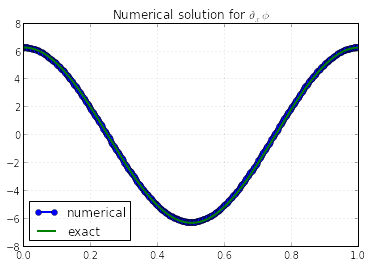

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# grid setup
Nx = 256
a, b = 0., 1.
x = np.linspace(a,b,Nx)

rho = 4*np.pi**2 * np.sin(2*np.pi * x) 
dphi = Poisson(rho,x, return_dphi = 'yes', return_phi = 'no')
dphi_exact = 2*np.pi*np.cos(2*np.pi*x)

plt.plot(x,dphi, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
plt.plot(x,dphi_exact, linewidth = 2, label = 'exact')
plt.hold('off')
plt.legend(loc = 'best')
plt.title('Numerical solution for $\partial_x\phi$')
plt.grid('on')

To find $\phi$, we can look at eq. (E.2) for example:

$$\phi (x) = (\tilde{\phi}(x) - \tilde{\phi}(\xi )) - \langle E \rangle (x - \xi ) + \phi (\xi )\qquad \qquad \text{(E.2, revisited)}$$

Here, $\langle E \rangle = 0$, $\xi = 0$, $\phi (\xi ) = 0$, so the above collapses to

$$\phi (x) = \tilde{\phi}(x) - \tilde{\phi}(\xi )$$

The value of $\tilde{\phi}(\xi = 0) = 0$ is obtained from the Fourier solution below, thus the solution is

$$\phi (x) = \tilde{\phi}(x)$$ 

should be computed directly from the Poisson solver. Note, we can obtain the same result by using the equivalent formulation (E.1):

$$\phi (x) = \tilde{\phi}(x) + \left[\frac{(\phi (\xi ) - \phi (\eta )) - (\tilde{\phi}(\xi ) - \tilde{\phi}(\eta ))}{\xi - \eta}\right] x + \left[\left(1 + \frac{\eta}{\xi - \eta}\right)\phi (\eta ) - \left(1 + \frac{\eta}{\xi - \eta}\right)\tilde{\phi}(\eta ) - \frac{\eta}{\xi - \eta}(\phi (\xi ) - \tilde{\phi}(\xi )) \right] \,\,\,\,\,\text{(E.1, revisted)}$$

where we can choose $\eta = 0$ for convenience, leaving the other endpoint as $\xi = 1$ by default. We know that $\phi (1) = \phi (0) = 0$, also we would find (below in the solver) that the function evaluation of $\tilde{\phi}$ at $\eta = 0$ and $\xi = 1$ would also give $0$. Thus, the above collapses to the same as above:

$$\phi (x) = \tilde{\phi}(x)$$

So, we see that eqs. (E.1) and (E.2) are compatible. Notwithstanding, in the calculation below, due to numerical error these function values for $\tilde{\phi}$ may not be quite zero so we include them per eq. (E.2) for consistency.

the value of phi_tilde at x = 0 is 0.0121757


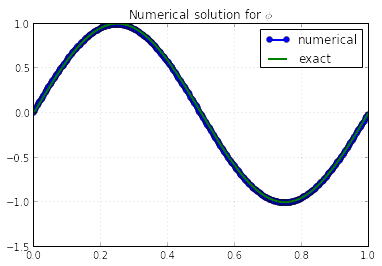

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

phi_tilde = Poisson(rho,x, return_dphi = 'no', return_phi = 'yes')
phi_exact = np.sin(2*np.pi*x)
dx = (b - a) / Nx # defined in previous code cell
E_avg = np.sum(phi_exact)*dx

phi = phi_tilde - E_avg*x - phi_tilde[0]
print "the value of phi_tilde at x = 0 is %g" % phi_tilde[0]

plt.plot(x,phi, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
plt.plot(x,phi_exact, linewidth = 2, label = 'exact')
plt.hold('off')
plt.legend(loc = 'best')
plt.title('Numerical solution for $\phi$')
plt.grid('on')

The solver worked given we implicitly had (homogeneous) Dirichlet boundary conditions which guarantees uniquess. The next example, similar to section D.3. needs to be reworked so that a unique solution is obtainable (i.e. there, we specified the electric field was chosen based on a midpoint value enforcement, this sort of non-boundary value is not sufficient for a unique solution to Poisson's equation, which require values to be specified at the boundary of the domain [Dirichlet, Neumann, or Robin]).

## E.3. Implementation and test case: non-periodic $\rho$ with $\langle \rho \rangle \neq 0$ and $\langle E \rangle \neq 0$

### (compare with section D.3.)

In this section, we select the charge distribution as:

$$\rho (x) = 4\pi^2\sin (2\pi x) + 2\pi x, \qquad \qquad x\in [0,1]$$

\begin{eqnarray*}
&& \\
\text{boundary values: } & \rho(0) = 0, & \rho (1) = 2\pi \\
\text{average: } & \langle \rho \rangle = \pi & \\
\end{eqnarray*}

then, since $\partial_x^2\phi (x) = -\rho (x)$,

$$\phi (x) = \sin (2\pi x) - \frac{1}{3}\pi x^3 + \pi x, \qquad \qquad x\in [0,1]$$

\begin{eqnarray*}
&& \\
\text{boundary values} & \phi (0) = 0 , & \phi (1) = 2\pi /3 \simeq 2.094 \\
\text{average: } & \langle \phi \rangle \simeq 1.309
\end{eqnarray*}

where we have chosen the above boundary values. The derivative $\partial_x\phi$ can be found by differentiating:

$$\partial_x\phi (x) = 2\pi\cos (2\pi x) - \pi x^2 + \pi , \qquad \qquad x\in [0,1]$$

\begin{eqnarray*}
&& \\
\text{endpoints: } & \partial_x\phi (0) = 3\pi \simeq 9.425, & \partial_x\phi (1) = 2\pi \\
\text{average: } & \langle \partial_x\phi \rangle = 2\pi / 3 \simeq 2.094 & \\
\end{eqnarray*}

Thus, we assess if the method can reproduce the solution $\phi$ and $\partial_x\phi$ given the equation:

$$\text{Test problem: } \qquad \frac{\partial^2\phi}{\partial x^2} = -\rho (x) ,\quad x\in [0, 1]$$

where the charge density is defined just above. <b> We use the education we have learned from section D.3. which informs we must zero pad an extended domain to obtain a solution for this non-periodic density case</b>.

Consider an extended domain as before, $\mathcal{D}_{\mathcal{X}} = [-5,6] \supset \mathcal{D}_x$, where $\mathcal{D}_x = [0,1]$ is the problem domain. The solver applied ont his extended (zero padded) domain produces a solution $\tilde{\phi}_{ext}$ in the extended domain such that $\langle\tilde{\phi}_{ext}\rangle_{x\in [-5,6]} = 0$. We require the fluctuating component $\tilde{\phi}$ of the solution in the problem domain $[0,1]$, defined such that $\langle\tilde{\phi}\rangle_{x\in [0,1]} = 0$. Thus, as before we write $\tilde{\phi} = \tilde{\phi}_{ext} - \langle \tilde{\phi}_{ext}\rangle_{x\in [0,1]}$ in the domain $x\in [0,1]$. After obtaining $\tilde{\phi}$ we can proceed with including the boundary value information as above (e.g. eqs. (E.1) or (E.2)).

### E.3.1. Grid and exact solution setup

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# solution grid setup, xn
Nxn = 1024
an, bn = -5., 6.
Ln = bn - an
dxn = Ln / (Nxn - 1)
xn = np.linspace(an,bn,Nxn)

# designate a nonzero domain, "interior"
interior_ind = np.where( (xn >= 0) & (xn <= 1))

rho_n = np.zeros(Nxn)
rho_n[interior_ind] = 4*np.pi**2 * np.sin(2*np.pi*xn[interior_ind]) + 2*np.pi*xn[interior_ind]
# rho_n already 0 outside of this domain

### E.3.2. Numerical solutions for $\partial_x\phi$

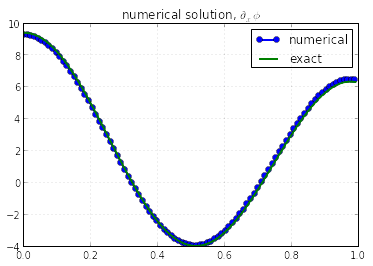

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

a, b = 0., 1.
dphi_exact = 2*np.pi * np.cos(2*np.pi * xn[interior_ind]) - np.pi*xn[interior_ind]**2 + np.pi
dphi_avg = np.sum(dphi_exact)*dxn / (b - a)

dphi_tilde_ext = Poisson(rho_n,xn, return_dphi = 'yes', return_phi = 'no') # the label n means "numerical"
dphi_tilde_int_avg = np.sum(dphi_tilde_ext[interior_ind])*dxn / (b - a)

dphi_hat_tilde_ext = dphi_tilde_ext - dphi_tilde_int_avg
dphi_tilde = dphi_hat_tilde_ext[interior_ind]
dphi = dphi_tilde + dphi_avg

plt.plot(xn[interior_ind], dphi, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
plt.plot(xn[interior_ind],dphi_exact, linewidth = 2, label = 'exact')
plt.legend(loc = 'best')
plt.title('numerical solution, $\partial_x\phi$')
plt.grid('on')

#### Error $\partial_x\phi - \partial_x\phi_{exact}$

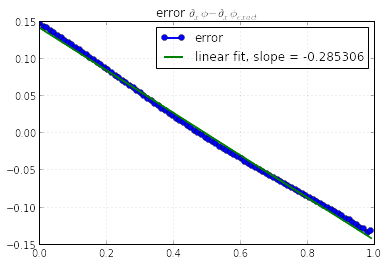

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

error_dphi = dphi_exact - dphi
linear_fit_coeffs = np.polyfit(xn[interior_ind], error_dphi, 1)
linear_fit = linear_fit_coeffs[0]*xn[interior_ind] + linear_fit_coeffs[1]

plt.plot(xn[interior_ind], error_dphi, linewidth = 2, marker = 'o', label = 'error')
plt.plot(xn[interior_ind], linear_fit, linewidth = 2, label = 'linear fit, slope = %g' % linear_fit_coeffs[0])
plt.xlim([0,1])
plt.legend(loc = 'best')
plt.title('error $\partial_x\phi - \partial_x\phi_{exact}$')
plt.grid('on')

### E.3.3. Numerical solutions for $\phi$

We assemble the total solution for $\phi$ (after enforcing the average value in the problem domain is the same as the exact solution) from eq. (E.1)

$$\phi (x) = \tilde{\phi}(x) + \left[\frac{(\phi (\xi ) - \phi (\eta )) - (\tilde{\phi}(\xi ) - \tilde{\phi}(\eta ))}{\xi - \eta}\right] x + \left[\left(1 + \frac{\eta}{\xi - \eta}\right)\phi (\eta ) - \left(1 + \frac{\eta}{\xi - \eta}\right)\tilde{\phi}(\eta ) - \frac{\eta}{\xi - \eta}(\phi (\xi ) - \tilde{\phi}(\xi )) \right] \,\,\,\,\,\text{(E.1, revisted)}$$

here, we choose $\eta = 0$ for convenience and $\xi = 1$, we are given that $\phi (0) = 0$ whereas $\phi (1) = 2\pi / 3$, the function evaluations of $\tilde{\phi}$ at each endpoint are obtained from the solver itself. Thus, the above collapses to:

$$\phi (x) = \tilde{\phi}(x) + \left[2\pi / 3 - (\tilde{\phi}(1) - \tilde{\phi}(0))\right] x -\tilde{\phi}(0) \qquad (E.1*)$$

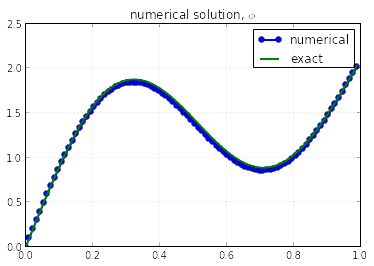

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

a, b = 0., 1.
phi_exact = np.sin(2*np.pi * xn[interior_ind]) - 1/3.*np.pi*xn[interior_ind]**3 + np.pi*xn[interior_ind]

phi_tilde_ext = Poisson(rho_n,xn, return_dphi = 'no', return_phi = 'yes') # the label n means "numerical"
phi_tilde_int_avg = np.sum(phi_tilde_ext[interior_ind])*dxn / (b - a)

phi_hat_tilde_ext = phi_tilde_ext - phi_tilde_int_avg
phi_tilde = phi_hat_tilde_ext[interior_ind]

# assemble phi per eq. (E.1*), note that x = 0 corresponds to phi_tilde[0], x = 1 corresponds to phi_tilde[-1]

phi = phi_tilde + (2*np.pi / 3 - (phi_tilde[-1]  \
                                  - phi_tilde[0]))*xn[interior_ind] \
                                  - phi_tilde[0]
                   

plt.plot(xn[interior_ind], phi, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
plt.plot(xn[interior_ind],phi_exact, linewidth = 2, label = 'exact')
plt.legend(loc = 'best')
plt.xlim([0,1])
plt.title('numerical solution, $\phi$')
plt.grid('on')

#### Error $\phi - \phi_{exact}$

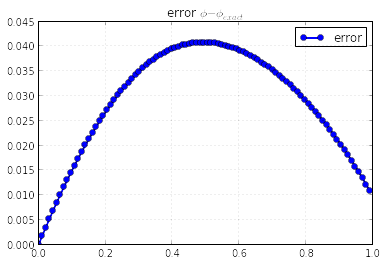

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

error_phi = phi_exact - phi
linear_fit_coeffs = np.polyfit(xn[interior_ind], error_phi, 1)
linear_fit = linear_fit_coeffs[0]*xn[interior_ind] + linear_fit_coeffs[1]

plt.plot(xn[interior_ind], error_phi, linewidth = 2, marker = 'o', label = 'error')
plt.xlim([0,1])
plt.legend(loc = 'best')
plt.title('error $\phi - \phi_{exact}$')
plt.grid('on')

# Conclusions

A pseudo-spectral solver was developed for the solution of either Gauss' law or Poisson's equation. The notebook stepped through periodic solutions and showed the numerical results agree well with the exact solutions. For non-periodic circumstances, a prescription for using the Fourier solution by zero-padding an extended domain was shown to work well. Thus, pseudo-spectral solvers can be used for non-periodic cases; however, at the increased computational cost of having to simulate more grid points outside of the problem domain in order to converge on an appropriate solution. Based on experience in test cases above, the extended domain $[A,B]$ has to be several times larger than the problem domain $[a,b]$ (i.e. $A \ll a, B \gg b$) in order to produce accurate results (cf. section D.3.5).

# References

[1] Y. Güçlü, A.J. Christlieb and W.N.G. Hitchon, Arbitrarily high order Convected Scheme solution of the Vlasov-Poisson system (2013).

[2] Discrete Fourier Transform (numpy.fft):  http://docs.scipy.org/doc/numpy/reference/routines.fft.html#module-numpy.fft

# Appendix

## Ap. 1 Uniqueness theorem for Poisson's equation

The proofing is simple and popular, the identical stepthrough can be found in any electrodynamics texts or elsewhere. We proceed by considering the possibility of two distinct solutionf $\phi_1$ and $\phi_2$ that satisfy the same Poisson's equation$:

$$\nabla^2\phi_1 = -\rho$$

$$\nabla^2\phi_2 = -\rho$$

Taking the difference of the above two equations:

$$\nabla^2\phi_2 - \nabla^2\phi_1 = 0$$

which is equivalent to the statement that the difference in potentials $\phi_{\Delta} = \phi_2 - \phi_1$ satisfies Laplace's equation:

$$\nabla^2\phi_{\Delta} = 0 \qquad \qquad (**)$$

Recall the vector identity:

$$\vec{\nabla}\cdot (\psi \vec{A}) = \vec{A}\cdot\vec{\nabla}\psi + \psi\vec{\nabla}\cdot\vec{A}$$

Writing $\psi = \phi_{\Delta}$, and $\vec{A} = \vec{\nabla}\phi_{\Delta}$, the above becomes

\begin{eqnarray*}
\vec{\nabla}\cdot (\phi_{\Delta} \vec{\nabla}\phi_{\Delta}) & = & \underbrace{\vec{\nabla}\phi_{\Delta}\cdot\vec{\nabla}\phi_{\Delta}}_{=\, (\vec{\nabla}\phi_{\Delta})^2} + \phi_{\Delta}\underbrace{\vec{\nabla}\cdot \vec{\nabla}\phi_{\Delta}}_{=\, \nabla^2\phi_{\Delta}} \\
&& \\
\vec{\nabla}\cdot (\phi_{\Delta} \vec{\nabla}\phi_{\Delta}) & = & (\vec{\nabla}\phi_{\Delta})^2 + \phi_{\Delta}\nabla^2\phi_{\Delta} \\
&&\\
\phi_{\Delta}\nabla^2\phi_{\Delta} & = & \vec{\nabla}\cdot (\phi_{\Delta} \vec{\nabla}\phi_{\Delta}) - (\vec{\nabla}\phi_{\Delta})^2 + \phi_{\Delta}\nabla^2\phi_{\Delta} 
\end{eqnarray*}

Multiplying eq. $(**)$ by $\phi_{\Delta}$ allows a substitution using this last line:


\begin{eqnarray*}
\phi_{\Delta} \nabla^2\phi_{\Delta} & = & 0 \\
&&\\
\vec{\nabla}\cdot (\phi_{\Delta} \vec{\nabla}\phi_{\Delta}) - (\vec{\nabla}\phi_{\Delta})^2 & = & 0\\
&& \\
\vec{\nabla}\cdot (\phi_{\Delta} \vec{\nabla}\phi_{\Delta}) & = & (\vec{\nabla}\phi_{\Delta})^2 
\end{eqnarray*}

To make progress, integrate over the domain volume $\mathcal{V}$ with bounding surface $\partial\mathcal{S}$:

\begin{eqnarray*}
\int_{\mathcal{V}}d^3\vec{x} \vec{\nabla}\cdot (\phi_{\Delta} \vec{\nabla}\phi_{\Delta}) & = & \int_{\mathcal{V}}d^3\vec{x} (\vec{\nabla}\phi_{\Delta})^2 \\
\int_{\mathcal{\partial\mathcal{S}}}d^2\vec{x} \cdot (\phi_{\Delta} \vec{\nabla}\phi_{\Delta}) & = &  \int_{\mathcal{V}}d^3\vec{x} (\vec{\nabla}\phi_{\Delta})^2
\end{eqnarray*}

If the left-hand side were to vanish, then we would have

$$0 = \int_{\mathcal{V}}d^3\vec{x} (\vec{\nabla}\phi_{\Delta})^2$$

<b>which is a statement of uniqueness in the gradient of $\phi$</b> since in order for the integral to vanish above, we note the positive definite quantity $\vec{\nabla}\phi_{\Delta}$ can only be zero. Recalling $\phi_{\Delta} = \phi_2 - \phi_1$, this means $\vec{\nabla}\phi_1 = \vec{\nabla}\phi_2$.

In order to understand when this can happen, we note this means the left-hand side must be zero:

$$\int_{\mathcal{\partial\mathcal{S}}}d^2\vec{x} \cdot (\phi_{\Delta} \vec{\nabla}\phi_{\Delta}) = 0$$

Thus, various boundary conditions can give rise to unique solutions:

<ol>
<li> Dirichlet boundaries
<li> Neumann boundaries
<li> Mixed (Robin) boundary conditions
</ol>

As concerns (1); to remind us of our goal, we have asserted there exist two distinct solutions $\phi_1$ and $\phi_2$ to Poisson's equation for a given volume and bounding surface. It is clear that if on the bounding surface $\partial\mathcal{S}$ the values of $\phi_1$ and $\phi_2$ were different, they would not be able to satisfy the same Poisson's equation. Thus, we understand that $\phi_1|_{\partial\mathcal{S}} = \phi_2|_{\partial\mathcal{S}} = \phi_S$ on $\partial\mathcal{S}$. Hence, $\phi_{\Delta}|_{\partial\mathcal{S}} = \phi_2|_{\partial\mathcal{S}} - \phi_1|_{\partial\mathcal{S}} = \phi_S - \phi_S = 0$.

As concerns (2): similar reasoning as applied to the normal derivatives on the surface gives the same result.

Thus, it is understood that a mixture of these two permit case (3) to be understood as following.

The gradient $\vec{\nabla}\phi$ is unique if it is sufficiently specified, and thus the electric field $\vec{E} = -\vec{\nabla}\phi$ is unique. To understand that the potential $\phi$ itself is unique, we can see that the Laplace equation $\nabla^2\phi_{\Delta} = 0$ implies $\phi_{\Delta} = \phi_2 - \phi_1$ is a harmonic function, which implies that $\phi_{\Delta} = 0$ since $\phi_{\Delta}|_{\partial\mathcal{S}} = 0$ (i.e. $\phi_1|_{\partial\mathcal{S}} = \phi_2|_{\partial\mathcal{S}}$) everywhere on the solution domain, hence $\phi_1 = \phi_2$ and <b>the potential $\phi$ is unique</b> given the objective function $\phi_{\Delta} = \phi_2 - \phi_1 = 0$ is harmonic.